Status: complete

Conclusions: The new SPRITE Zero R1-R4 tag plates (stock plates from IDT dated 2024-02-07 (bottom) and 2024-02-08 (top); annealed by me on April 25, 2024 and aliquotted into several 45 uM, 4.5 uM, and 0.45 uM plates) are extremely clean with <0.051% measured contamination across rounds R1-R4.

Notes
- "Sample" is used below to refer to different i5/i7 sequencing indices. These presumably correspond to a series of wells - for example, sample 1 (indices = D1 i5, F1 i7 - see [library sheet](https://docs.google.com/spreadsheets/d/13szKKS6Cz1a9e_Qv3nCFF5_OHZZFE2YO_clUG1cFUcI)) corresponds to tags R1_1, R2_1, R3_1, R4_1.
  - However, the analysis shows that the sequencing indices are more contaminated than the tags, such that different correct tag strings may be associated with the same sequencing index.
  - Furthermore, it appears as if sample 11 was contaminated by a different single cell barcoding experiment that used the sample sequencing indices. However, the tags R1_11, R2_11, R3_11, and R4_11 themselves are still exquisitely clean.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [2]:
# Python Standard Library modules
import collections
import gzip
import itertools
import os
import re
import subprocess
import sys

# Basic SciPy packages
import numpy as np
import scipy
import pandas as pd

# Visualization packages
import matplotlib.collections
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly.graph_objects as go
import plotly.express as px

from tqdm.auto import tqdm
import IPython.display

# Custom modules
sys.path.append('../scripts')
import string_distances
import parse_barcodes
from helpers import fastq_parse

In [3]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2024-05-14T12:37:45.546776-07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.14.0-162.23.1.el9_1.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

conda environment: py3

numpy     : 1.23.5
sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
re        : 2.2.1
scipy     : 1.11.1
plotly    : 5.15.0
IPython   : 8.14.0
matplotlib: 3.7.2
seaborn   : 0.12.2
pandas    : 2.0.2



In [4]:
%%bash
splitcode --version

splitcode, version 0.29.1


In [5]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20240507_tagPlateContamination')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20240507_tagPlateContamination')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20240507_tagPlateContamination')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20240507_tagPlateContamination')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

# Constants and Helpers

In [6]:
ROUNDS = ['R1', 'R2', 'R3', 'R4']

# Data

- [Enhanced Sample Sheet](https://docs.google.com/spreadsheets/d/1ylVcBUnhzmlYFGPkwfzejb5Fo5FiODIVFa5inqanpLQ)
- [Library sheet](https://docs.google.com/spreadsheets/d/13szKKS6Cz1a9e_Qv3nCFF5_OHZZFE2YO_clUG1cFUcI)
- [Benchling notebook: 2024-04-25 Tag Plate Contamination, v4](https://benchling.com/s/etr-8ry7GOBbZVL8V697v2hC)

In [7]:
path_df_data = os.path.join(DIR_RESULTS, 'sample_info.csv')
if not os.path.exists(path_df_data):
    regex_fastq_files = re.compile((
        r'(?P<filename>tagPlateContamination_barcode-(?P<sample>[0-9]+)_R(?P<read>1|2).fastq.gz)'))
    
    files_fastq = sorted([file for file in os.listdir(DIR_DATA) if file.endswith('.fastq.gz')])
    df_data = pd.DataFrame([
        regex_fastq_files.match(file).groupdict() for file in files_fastq]) \
        .astype(dict(read=int, sample=int))
    
    popen_counts = dict()
    for (sample, read), group in df_data.groupby(['sample', 'read']):
        filename = group['filename'].item()
        cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
        popen_counts[(sample, read)] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    
    df_data['n_reads'] = int(0)
    for (sample, read), popen in popen_counts.items():
        count, err = popen.communicate()
        assert err is None and popen.returncode == 0
        df_data.loc[(df_data['sample'] == sample) & (df_data['read'] == read), 'n_reads'] = int(count.decode().strip())

    assert (df_data.groupby('sample')['n_reads'].unique().map(len) == 1).all()

    df_data = (
        df_data
        .sort_values(['sample', 'read'])
        .reset_index(drop=True)
    )
    df_data.to_csv(path_df_data, index=False)
else:
    df_data = pd.read_csv(path_df_data, index_col=False)

In [8]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)
display(df_data)

Total number of paired reads: 1586046


filename  sample  read  n_reads
0    tagPlateContamination_barcode-1_R1.fastq.gz       1     1    20266
1    tagPlateContamination_barcode-1_R2.fastq.gz       1     2    20266
2    tagPlateContamination_barcode-2_R1.fastq.gz       2     1    89085
3    tagPlateContamination_barcode-2_R2.fastq.gz       2     2    89085
4    tagPlateContamination_barcode-3_R1.fastq.gz       3     1    94579
5    tagPlateContamination_barcode-3_R2.fastq.gz       3     2    94579
6    tagPlateContamination_barcode-4_R1.fastq.gz       4     1    82644
7    tagPlateContamination_barcode-4_R2.fastq.gz       4     2    82644
8    tagPlateContamination_barcode-5_R1.fastq.gz       5     1   120268
9    tagPlateContamination_barcode-5_R2.fastq.gz       5     2   120268
10   tagPlateContamination_barcode-6_R1.fastq.gz       6     1    90574
11   tagPlateContamination_barcode-6_R2.fastq.gz       6     2    90574
12   tagPlateContamination_barcode-7_R1.fastq.gz       7     1    69813
13   tagPlateContamination_barcode-7_R2.fastq.gz       7     2    69813
14   tagPlateContamination_barcode-8_R1.fastq.gz       8     1    71894
15   tagPlateContamination_barcode-8_R2.fastq.gz       8     2    71894
16   tagPlateContamination_barcode-9_R1.fastq.gz       9     1    88358
17   tagPlateContamination_barcode-9_R2.fastq.gz       9     2    88358
18  tagPlateContamination_barcode-10_R1.fastq.gz      10     1    85020
19  tagPlateContamination_barcode-10_R2.fastq.gz      10     2    85020
20  tagPlateContamination_barcode-11_R1.fastq.gz      11     1   131407
21  tagPlateContamination_barcode-11_R2.fastq.gz      11     2   131407
22  tagPlateContamination_barcode-12_R1.fastq.gz      12     1    69926
23  tagPlateContamination_barcode-12_R2.fastq.gz      12     2    69926
24  tagPlateContamination_barcode-13_R1.fastq.gz      13     1    44013
25  tagPlateContamination_barcode-13_R2.fastq.gz      13     2    44013
26  tagPlateContamination_barcode-14_R1.fastq.gz      14     1    53492
27  tagPlateContamination_barcode-14_R2.fastq.gz      14     2    53492
28  tagPlateContamination_barcode-15_R1.fastq.gz      15     1    55986
29  tagPlateContamination_barcode-15_R2.fastq.gz      15     2    55986
30  tagPlateContamination_barcode-16_R1.fastq.gz      16     1    55503
31  tagPlateContamination_barcode-16_R2.fastq.gz      16     2    55503
32  tagPlateContamination_barcode-17_R1.fastq.gz      17     1    47438
33  tagPlateContamination_barcode-17_R2.fastq.gz      17     2    47438
34  tagPlateContamination_barcode-18_R1.fastq.gz      18     1    46225
35  tagPlateContamination_barcode-18_R2.fastq.gz      18     2    46225
36  tagPlateContamination_barcode-19_R1.fastq.gz      19     1    47573
37  tagPlateContamination_barcode-19_R2.fastq.gz      19     2    47573
38  tagPlateContamination_barcode-20_R1.fastq.gz      20     1    49802
39  tagPlateContamination_barcode-20_R2.fastq.gz      20     2    49802
40  tagPlateContamination_barcode-21_R1.fastq.gz      21     1    71221
41  tagPlateContamination_barcode-21_R2.fastq.gz      21     2    71221
42  tagPlateContamination_barcode-22_R1.fastq.gz      22     1    60063
43  tagPlateContamination_barcode-22_R2.fastq.gz      22     2    60063
44  tagPlateContamination_barcode-23_R1.fastq.gz      23     1    16508
45  tagPlateContamination_barcode-23_R2.fastq.gz      23     2    16508
46  tagPlateContamination_barcode-24_R1.fastq.gz      24     1    24388
47  tagPlateContamination_barcode-24_R2.fastq.gz      24     2    24388

# FastQC

Expectations
- Read 1: good sequence diversity due to UMIs on the oligo
  - No adapter content expected, since expected insert length is identical to the read 1 length of 120 bp.
- Read 2: near total duplication from each sample, since all barcodes from the same well should have the same R1, R2, R3, R4 and NYLigOdd tags
  - Adapter content expected at 120 bp, since read length of 180 bp exceeds expected insert length of 120 bp.

Gross observations: matches expectations

In [9]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
source ~/.bashrc
DIR_FASTQC_OUT="$DIR_PROC/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_PROC/fastqc"
    cd "$DIR_DATA"
    conda activate chipdip
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

# Count barcodes

Expected read structures
- Benchling DNA sequence: [Oligo (PC50_12merUMI) + R1-R4 + NYLigOdd PCR Product (2Puni + 2Pbc)](https://benchling.com/s/seq-mk3R23jRq7LL86kedM7b)
- Splitcode config Google Sheet: https://docs.google.com/spreadsheets/d/1Ta5gDLse5W-bb3-8YYQrKoZYKzdtltXLJeL7wz1up28
  - Sheet `expected_structure`: used here to identify full, expected barcodes
  - Sheets `terms_and_overhangs` and `terms_and_overhangs_groups`: used later for troubleshooting barcode identification for sample 11, which had unusually low read assignment rate using the `expected_structure` config.

| Component                                 | Length | R1 coordinates | R2 coordinates |
| ----------------------------------------- | ------ | -------------- | -------------- |
| 2Puni adapter, Illumina universal adapter | 11     | n/a            | 120:131        |
| Oligo UMI                                 | 12     | 0:12           | 108:120        |
| LigEven / Even overhang                   | 7      | 12:19          | 101:108        |
| R1 unique sequence                        | 16     | 19:35          | 85:101         |
| LigR1 / R1 overhang                       | 7      | 35:42          | 78:85          |
| R2 unique sequence                        | 16     | 42:58          | 62:78          |
| LigR2 / R2 overhang                       | 7      | 58:65          | 55:62          |
| R3 unique sequence                        | 16     | 65:81          | 39:55          |
| LigR3 / R3 overhang                       | 7      | 81:88          | 32:39          |
| R4 unique sequence                        | 16     | 88:104         | 16:32          |
| LigR4 / R3 overhang                       | 7      | 104:111        | 9:16           |
| NYLigR4Stg_1 unique sequence              | 9      | 111:120        | 0:9            |
| 2Pbc adapter, Illumina universal adapter  | 11     | n/a (exceeds read length)        | n/a            |

1. Add barcode and UMI to read name:

   `@read::[LigEven][R1Top_<R1_1>][LigR1][R2Top_<R2_1>][LigR2][R3Top_<R3_1>][LigR3][R4Top_<R4_1>][LigR4][NYLigR4StgTop_1][NYStgBot_1][R4][R4Bot_<R4_2>][R3][R3Bot_<R3_2>][R2][R2Bot_<R2_2>][R1][R1Bot_<R1_2>][Even][2Puni] RX:Z:<umi1>-<umi2>`

2. Calculate barcode counts

## Tag identification by splitcode

In [10]:
path_config = os.path.join(DIR_AUX, 'splitcode_config.tsv')

In [11]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_PROJECT} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_PROJECT="$3"
PATH_CONFIG="$4"

PATH_SBATCH="$DIR_PROJECT/scripts/splitcode2.sbatch"

for PATH_R1 in "$DIR_DATA"/*_R1.fastq.gz; do
    SAMPLE="$(echo "$PATH_R1" | grep -o -E -e 'barcode-[0-9]+' | sed -e 's/barcode-//')"
    PATH_R2="$(ls "${DIR_DATA}/tagPlateContamination_barcode-${SAMPLE}"_R2.fastq.gz)"
    PATH_MAPPING="$DIR_PROC/mapping-${SAMPLE}.tsv"
    PATH_SUMMARY="$DIR_PROC/summary-${SAMPLE}.json"
    PATH_OUTPUT="$DIR_PROC/read_barcodes-${SAMPLE}.txt.gz"

    if [ ! -f "$PATH_OUTPUT" ]; then

        # submit as SLURM jobs
        PATH_SBATCH_ERROR="$DIR_PROC/sbatch-${SAMPLE}.err"
        PATH_SBATCH_OUT="$DIR_PROC/sbatch-${SAMPLE}.out"
        sbatch --error="$PATH_SBATCH_ERROR" --out="$PATH_SBATCH_OUT" \
            "$PATH_SBATCH" \
            "$PATH_CONFIG" "$PATH_MAPPING" "$PATH_SUMMARY" "$PATH_OUTPUT" "$PATH_R1" "$PATH_R2"

        # run locally
        # splitcode -c "$PATH_CONFIG" \
        #     --nFastqs=2 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
        #     --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" --output=/dev/stdout,/dev/null \
        #     "$PATH_R1" "$PATH_R2" |
        # awk '$1 ~ /^>/' |
        # pigz -p 8 > "$PATH_OUTPUT"
    fi
done

## Compare with exact matching

In [12]:
dict_complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
def reverse_complement(s, allow_noncanonical=False):
    if allow_noncanonical is False:
        return ''.join(dict_complement[base] for base in reversed(s))
    else:
        return ''.join(dict_complement.get(base, base) for base in reversed(s))

In [13]:
read1_structure = (
    ('umi', 12),
    ('ids', 'LigEven'),
    ('groups', 'R1Top'),
    ('ids', 'LigR1'),
    ('groups', 'R2Top'),
    ('ids', 'LigR2'),
    ('groups', 'R3Top'),
    ('ids', 'LigR3'),
    ('groups', 'R4Top'),
    ('ids', 'LigR4'),
    ('ids', 'NYLigR4StgTop_1')
)

read2_structure = (
    ('ids', 'NYStgBot_1'),
    ('ids', 'R4'),
    ('groups', 'R4Bot'),
    ('ids', 'R3'),
    ('groups', 'R3Bot'),
    ('ids', 'R2'),
    ('groups', 'R2Bot'),
    ('ids', 'R1'),
    ('groups', 'R1Bot'),
    ('ids', 'Even'),
    ('umi', 12),
    ('ids', '2Puni')
)

In [14]:
def structure_to_regex(structure, config):
    '''
    Convert a specified read structure into a regular expression 

    Args
    - structure: sequence of 2-tuple
        Sequence of (part, name or #), in order that the parts appear in the read
        - part: one of 'umi', 'ids', or 'groups'
          - 'umi': # gives the length of the UMI in bp
          - 'ids': the name is name of a particular tag in `config`
          - 'groups': the name is the name of a group of tags in `config`
    - config: pandas.DataFrame
        Barcode config table, following splitcode's format. Must have the columns groups, ids, and tags.

    Returns
    - pattern: re.Pattern
        Regular expression
    - group_tag_to_id: dict(str -> dict(str -> str))
        Map from tag group name to a map from sequence to tag name
    '''
    group_tag_to_id = dict()
    pattern = '^'
    for part, name in structure:
        if part == 'umi':
            pattern += f'(?P<umi>[ATCGN]{{{name}}})'
        elif part == 'ids':
            tags = config.loc[config['ids'] == name, 'tags']
            pattern += f'({"|".join(tags)})'
        elif part == 'groups':
            tags = config.loc[config['groups'] == name, ['tags', 'ids']].drop_duplicates().set_index('tags').squeeze(axis=1)
            assert tags.index.is_unique
            pattern += f'(?P<__group__{name}>' + '|'.join(tags.index) + ')'
            group_tag_to_id[name] = tags.to_dict()
        else:
            raise ValueError
    return re.compile(pattern), group_tag_to_id

In [15]:
def tag_id_exact(seq, structure, pattern, group_tag_to_id):
    '''
    Identify tags in a string sequence using regular expression matching.

    Args
    - seq: str
        Query sequence within which to match barcode
    - structure: sequence of 2-tuple
        Sequence of (part, name or #), in order that the parts appear in the read
        - part: one of 'umi', 'ids', or 'groups'
          - 'umi': # gives the length of the UMI in bp
          - 'ids': the name is name of a particular tag in `config`
          - 'groups': the name is the name of a group of tags in `config`
    - pattern: re.Pattern
        Regular expression pattern of target sequence
    - group_tag_to_id: dict(str -> dict(str -> str))
        Map from tag group name to a map from sequence to tag name

    Returns: 2-tuple or None (if no match)
    - barcode: str
        List of matched barcode tags, in order
    - umi: str
        Matched UMI sequence
    '''
    match = pattern.search(seq)
    if not match:
        return None
    match = match.groupdict()
    barcode = []
    for part, name in structure:
        if part == 'ids':
            barcode.append(name)
        elif part == 'groups':
            barcode.append(group_tag_to_id[name][match[f'__group__{name}']])
    return barcode, match['umi']

def paired_tag_extract(seq1, structure1, pattern1, group_tag_to_id1,
                       seq2, structure2, pattern2, group_tag_to_id2):
    '''
    Identify tags in a read pair using regular expression matching.

    Args: see tag_id_exact()

    Returns: str or None
    - If either read in the read pair does not match their corresponding
      pattern, returns None.
    - If both reads in the read pair are matched by their corresponding
      regular expression, then return a barcode string in the format
      '[tag1][tag2]... RX:Z:[umi1]-[reverse_complement(umi2)]'
      where the string of tags is in the order of tags in read 1 followed
      by those in read 2.
    '''
    result1 = tag_id_exact(seq1, structure1, pattern1, group_tag_to_id1)
    if result1 is None:
        return None
    barcode1, umi1 = result1
    result2 = tag_id_exact(seq2, structure2, pattern2, group_tag_to_id2)
    if result2 is None:
        return None
    barcode2, umi2 = result2
    return ''.join((f'[{name}]' for name in barcode1 + barcode2)) + f' RX:Z:{umi1}-{reverse_complement(umi2)}'

In [16]:
# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

In [17]:
pattern1, group_tag_to_id1 = structure_to_regex(read1_structure, df_config)
pattern2, group_tag_to_id2 = structure_to_regex(read2_structure, df_config)

for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes_exact-{sample}.txt.gz')
    if not os.path.exists(path_read_barcodes):
        path_r1 = os.path.join(
            DIR_DATA,
            df_data.loc[(df_data['sample'] == sample) & (df_data['read'] == 1), 'filename'].item())
        path_r2 = os.path.join(
            DIR_DATA,
            df_data.loc[(df_data['sample'] == sample) & (df_data['read'] == 2), 'filename'].item())
        with gzip.open(path_r1, 'rt') as f1, \
             gzip.open(path_r2, 'rt') as f2, \
             gzip.open(path_read_barcodes, 'wt') as fout:
            paired_iterator = tqdm(
                zip(fastq_parse(f1), fastq_parse(f2)),
                total=df_data.loc[df_data['sample'] == sample, 'n_reads'].unique()[0])
            for (name1, seq1, _, _), (name2, seq2, _, _) in paired_iterator:
                read_name = name1.split()[0]
                assert read_name == name2.split()[0]
                barcode = paired_tag_extract(
                    seq1, read1_structure, pattern1, group_tag_to_id1,
                    seq2, read2_structure, pattern2, group_tag_to_id2)
                if barcode is None:
                    continue
                fout.write(f'{read_name}::{barcode}\n')

## Barcode identification metrics

- Number/proportion of "assigned" reads (i.e., reads matching expected read structure): average >87%, but sample 11 is particularly poor at ~51% reads assigned
- UMI validation: number of UMIs with `N`s
  - Note that the splitcode config used guarantees that a 12-bp UMI is identified for all "assigned" read pairs 

In [18]:
df_data['n_assigned'] = 0
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    with gzip.open(path_read_barcodes, 'r') as f:
        for i, _ in enumerate(f):
            continue
    df_data.loc[df_data['sample'] == sample, 'n_assigned'] = i + 1

In [19]:
df_data['n_assigned_exact'] = 0
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes_exact-{sample}.txt.gz')
    with gzip.open(path_read_barcodes, 'r') as f:
        for i, _ in enumerate(f):
            continue
    df_data.loc[df_data['sample'] == sample, 'n_assigned_exact'] = i + 1

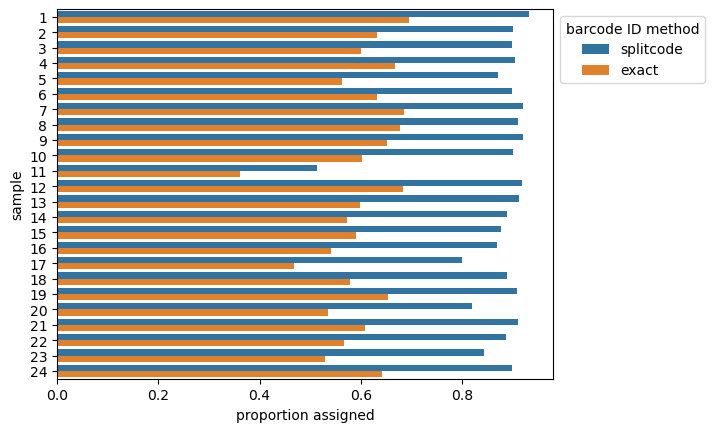

In [20]:
ax = sns.barplot(
    (
        df_data
        .drop_duplicates('sample')
        .assign(
            splitcode=df_data['n_assigned'] / df_data['n_reads'],
            exact=df_data['n_assigned_exact'] / df_data['n_reads'])
        .melt(
            id_vars='sample',
            value_vars=['splitcode', 'exact'],
            var_name='barcode ID method',
            value_name='proportion assigned'
        )
        .astype({'sample': 'category'})
    ),
    x='proportion assigned',
    y='sample',
    hue='barcode ID method',
)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
ax.figure.show()

In [21]:
print('Barcode identification statistics:', end='\n\n')
pd.concat(
    (df_data.drop_duplicates('sample').pipe(lambda df: df['n_assigned'] / df['n_reads']).describe().rename('splitcode'),
     df_data.drop_duplicates('sample').pipe(lambda df: df['n_assigned_exact'] / df['n_reads']).describe().rename('exact')),
    axis=1
)

Barcode identification statistics:



splitcode      exact
count  24.000000  24.000000
mean    0.874347   0.596922
std     0.083229   0.076226
min     0.513101   0.360544
25%     0.875523   0.566012
50%     0.898277   0.600468
75%     0.909584   0.651398
max     0.932547   0.694464

In [22]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
n_total="$(unpigz -c "$DIR_PROC"/read_barcodes-*.txt.gz | wc -l)"
n_umis="$(
    unpigz -c "$DIR_PROC"/read_barcodes-*.txt.gz |
    grep -E -e 'RX:Z:[ATCGN-]*N' |
    wc -l
)"
echo "Number of UMIs by containing Ns: $n_umis out of $n_total total assigned reads"

Number of UMIs by containing Ns: 9291 out of 1365841 total assigned reads


## Troubleshoot barcode identification of sample 11

Why does sample 11 only have 51.3% barcode identification rate?
- FastQC results
  - Read 1: Illumina adapter is unexpectedly detectable in ~37% of read 1 sequences at position ~100.
  - Read 2:
    - Per-base sequence content is not uniform over the first 9 bp, which would be expected since I used a single NYLigR4Stg_1 tag as the terminal tag. The non-dominant base is not uniform either, suggesting that the unexpected population does not have a uniform terminal tag.
    - Two populations of sequences are evident by where the Illumina adapter shows up: one, ~100 bp (unexpected); and another ~120 bp (expected).

### splitcode analysis

First, select only unassigned read 2 reads from sample 11

In [23]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_PROJECT} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_PROJECT="$3"
PATH_CONFIG="$4"

SAMPLE="11"
PATH_R1="${DIR_DATA}/tagPlateContamination_barcode-${SAMPLE}_R1.fastq.gz"
PATH_R2="${DIR_DATA}/tagPlateContamination_barcode-${SAMPLE}_R2.fastq.gz"
# PATH_UNASSIGNED_R1="$DIR_PROC/unassigned-${SAMPLE}_R1.fastq.gz"
PATH_UNASSIGNED_R2="$DIR_PROC/unassigned-${SAMPLE}_R2.fastq.gz"

# run locally
splitcode -c "$PATH_CONFIG" \
    --nFastqs=2 --assign --no-output --no-outb -t 8 \
    --mapping=/dev/null --unassigned=/dev/null,"$PATH_UNASSIGNED_R2" \
    "$PATH_R1" "$PATH_R2"

* Using a list of 205 tags (vector size: 206; map size: 5,292,780; num elements in map: 5,466,301)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20240507_tagPlateContamination/tagPlateContamination_barcode-11_R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data/20240507_tagPlateContamination/tagPlateContamination_barcode-11_R2.fastq.gz
* processing the reads ...
done 
* processed 131,407 reads, 67,425 reads were assigned


Search for all terminal tags and overhangs in read 2

In [24]:
# first check that none of the terminal tag and overhang sequences overlap, or contain on another
df_config_terms_overhangs = pd.read_csv(os.path.join(DIR_AUX, 'splitcode_config-terms_and_overhangs.tsv'), sep='\t', header=0)
all_seqs = set(df_config_terms_overhangs['tags'])
assert len(all_seqs) == len(df_config_terms_overhangs)
for tag in all_seqs:
    for tag2 in all_seqs:
        if tag2 == tag:
            continue
        if tag in tag2 or tag2 in tag:
            print(tag, tag2)

In [25]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_PROJECT} {DIR_AUX}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_PROJECT="$3"
DIR_AUX="$4"
PATH_CONFIG="${DIR_AUX}/splitcode_config-terms_and_overhangs.tsv"

SAMPLE="11"
PATH_MAPPING="$DIR_PROC/unassigned_mapping-${SAMPLE}_R2.tsv"
PATH_UNASSIGNED_R2="$DIR_PROC/unassigned-${SAMPLE}_R2.fastq.gz"

# run locally
splitcode -c "$PATH_CONFIG" \
    --nFastqs=1 --assign --no-output --no-outb -t 8 \
    --mapping="$PATH_MAPPING" \
    "$PATH_UNASSIGNED_R2"

* Using a list of 209 tags (vector size: 209; map size: 690; num elements in map: 690)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240507_tagPlateContamination/unassigned-11_R2.fastq.gz
* processing the reads ...
done 
* processed 63,982 reads, 62,314 reads were assigned


In [26]:
(
    pd.read_csv(
        os.path.join(DIR_PROC, 'unassigned_mapping-11_R2.tsv'),
        sep='\t',
        header=None,
        names=['final_barcode', 'barcode', 'count']
    )
    [['barcode', 'count']]
    .sort_values('count', ascending=False)
    .head(20)
)

barcode  count
4     NYStgBot_25,R3,R2,R1,Even,2Puni   1694
0     NYStgBot_40,R3,R2,R1,Even,2Puni   1669
12    NYStgBot_46,R3,R2,R1,Even,2Puni   1661
33  NYStgBot_1,R4,R3,R2,R1,Even,2Puni   1655
60    NYStgBot_45,R3,R2,R1,Even,2Puni   1649
15    NYStgBot_33,R3,R2,R1,Even,2Puni   1604
83    NYStgBot_41,R3,R2,R1,Even,2Puni   1547
11    NYStgBot_44,R3,R2,R1,Even,2Puni   1517
46    NYStgBot_28,R3,R2,R1,Even,2Puni   1496
87    NYStgBot_38,R3,R2,R1,Even,2Puni   1443
27    NYStgBot_35,R3,R2,R1,Even,2Puni   1431
70    NYStgBot_43,R3,R2,R1,Even,2Puni   1426
47    NYStgBot_42,R3,R2,R1,Even,2Puni   1413
78    NYStgBot_34,R3,R2,R1,Even,2Puni   1404
7     NYStgBot_31,R3,R2,R1,Even,2Puni   1400
57    NYStgBot_27,R3,R2,R1,Even,2Puni   1273
75    NYStgBot_30,R3,R2,R1,Even,2Puni   1263
16    NYStgBot_36,R3,R2,R1,Even,2Puni   1247
66    NYStgBot_39,R3,R2,R1,Even,2Puni   1235
68    NYStgBot_37,R3,R2,R1,Even,2Puni   1208

The above analysis suggests that this sublibrary, defined by this i5/i7 sequencing index pair, may have been contaminated by a single cell barcoding experiment ([2024-04-30 Single Cell Barcode Troubleshooting, v6](https://benchling.com/s/etr-P5LUVhFNbxu6iLM2CQEK); barcode structure = Oligo + R1-R3 + NYLigOdd) that I performed around the same time using similar sequencing indices.

In [27]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_PROJECT} {DIR_AUX}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_PROJECT="$3"
DIR_AUX="$4"
PATH_CONFIG="${DIR_AUX}/splitcode_config-terms_and_overhangs_groups.tsv"

SAMPLE="11"
PATH_UNASSIGNED_R2="$DIR_PROC/unassigned-${SAMPLE}_R2.fastq.gz"

# run locally
splitcode -c "$PATH_CONFIG" \
    --nFastqs=1 --assign --loc-names --no-outb --out-fasta -t 8 \
    --mapping=/dev/null --output=/dev/stdout \
    "$PATH_UNASSIGNED_R2" |
    awk '$1 ~ /^>/' |
    grep -o -E -e "LX:Z:.*" |
    sort |
    uniq -c |
    sort -n -r |
    head -n 20

* Using a list of 209 tags (vector size: 209; map size: 690; num elements in map: 690)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240507_tagPlateContamination/unassigned-11_R2.fastq.gz
* processing the reads ...
done 
* processed 63,982 reads, 62,314 reads were assigned


  16571 LX:Z:NYStgBot:0,0-10,R3:0,10-17,R2:0,33-40,R1:0,56-63,Even:0,79-86,2Puni:0,98-119
  12713 LX:Z:NYStgBot:0,0-9,R3:0,9-16,R2:0,32-39,R1:0,55-62,Even:0,78-85,2Puni:0,97-118
   2819 LX:Z:NYStgBot:0,0-10,R3:0,10-17,R2:0,33-40,R1:0,56-63,Even:0,79-86
   2071 LX:Z:NYStgBot:0,0-9,R3:0,9-16,R2:0,32-39,R1:0,55-62,Even:0,78-85
   1077 LX:Z:NYStgBot:0,0-10,R3:0,10-17,R2:0,33-40,R1:0,56-63,LigR3:0,68-75,Even:0,79-86,2Puni:0,98-119
    949 LX:Z:NYStgBot:0,0-9,R4:0,9-16,R3:0,32-39,R2:0,55-62,R1:0,78-85,Even:0,101-108,2Puni:0,120-141
    782 LX:Z:NYStgBot:0,0-9,R3:0,9-16,R2:0,32-39,R1:0,55-62,LigR3:0,67-74,Even:0,78-85,2Puni:0,97-118
    679 LX:Z:NYStgBot:0,0-9,R4:0,9-16,R3:0,32-39,R2:0,55-62,R1:0,78-85,Even:0,101-108
    562 LX:Z:NYStgBot:0,0-10,R3:0,10-17,R2:0,33-40,Even:0,78-85,2Puni:0,97-118
    490 LX:Z:NYStgBot:0,0-10,R3:0,10-17,R2:0,33-40,R1:0,56-63
    439 LX:Z:NYStgBot:0,0-10,R3:0,10-17,R2:0,33-40,R1:0,56-63,Even:0,78-85,2Puni:0,97-118
    381 LX:Z:NYStgBot:0,0-9,R3:0,9-16,R2:0,32-39,

These results confirm the previous suspicion: the predominant unassigned structure matches Oligo + R1-R3 + NYLigOdd, likely coming from my scBarcode v6 experiment.

## Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [barcode + UMI]
  - format: n/a
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `R4` `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts per barcode
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `R4`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: deduplicated counts per tag
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count` (deduplicated)

In [28]:
path_umi_validation = os.path.join(DIR_RESULTS, 'umi_validation.csv')
path_tag_counts = os.path.join(DIR_RESULTS, 'tag_counts.csv')
path_barcode_counts = os.path.join(DIR_RESULTS, 'barcode_counts.csv')
path_umi_ecdf = os.path.join(DIR_RESULTS, 'umi_ecdf.csv')

In [29]:
reprocess = not all(os.path.exists(path) for path in [path_umi_validation, path_tag_counts, path_barcode_counts, path_umi_ecdf])
print('reprocess:', reprocess)

reprocess: False


In [30]:
regex_barcode = re.compile((
    r'\[LigEven\]'
    r'\[R1Top_(?P<R1>\d+)\]'
    r'\[LigR1\]'
    r'\[R2Top_(?P<R2>\d+)\]'
    r'\[LigR2\]'
    r'\[R3Top_(?P<R3>\d+)\]'
    r'\[LigR3\]'
    r'\[R4Top_(?P<R4>\d+)\]'
    r'\[LigR4\]'
    r'\[NYLigR4StgTop_1\]'
    r'\[NYStgBot_1\]'
    r'\[R4\]'
    r'\[R4Bot_(?P<R4_2>\d+)\]'
    r'\[R3\]'
    r'\[R3Bot_(?P<R3_2>\d+)\]'
    r'\[R2\]'
    r'\[R2Bot_(?P<R2_2>\d+)\]'
    r'\[R1\]'
    r'\[R1Bot_(?P<R1_2>\d+)\]'
    r'\[Even\]'
    r'\[2Puni\]'
    r'\s+'
    r'RX:Z:(?P<umi>[ACGNT]*)-(?P<umi_2>[ACGNT]*)'
))

DTYPE_SAMPLE = pd.api.types.CategoricalDtype(categories=list(df_data['sample'].unique()))
DTYPE_COUNT_TYPE = pd.api.types.CategoricalDtype(categories=['raw', 'dedup'])
DTYPE_ROUNDS = pd.api.types.CategoricalDtype(categories=ROUNDS)

def count_barcodes(sample, regex, path_barcodes=None):
    '''
    From the read_barcodes file generated from a given sample and splitcode config,
    count the barcodes and UMIs, and tabulate in pandas DataFrames.

    Args
    - sample: str
        Sample name
    - regex: re.Pattern
        Regular expression pattern for barcode. Should contain named capture groups.
    
    Returns
    - df_barcode_counts: pandas.DataFrame
      - Only includes reads associated with 12 bp UMIs containing no Ns,
        and where the barcode identified from the forward and reverse reads match
      - Columns
        - R1, R2, R3, R4: np.uint8
        - count: np.int64
        - count_dedup: np.int64
        - sample: DTYPE_SAMPLE
    - df_umi_counts: pandas.DataFrame
      - R1, R2, R3, R4, R1_2, R2_2, R3_2, R4_2: np.uint8
      - umi, umi_2: str
      - count: np.int64
      - sample: DTYPE_SAMPLE
    - n_unmatched: int
        Number of reads whose barcodes did not match the provided regex.
    '''
    if path_barcodes is None:
        path_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    with gzip.open(path_barcodes, 'rt') as f:
        df_umi_counts, n_unmatched, unmatched = parse_barcodes.barcodes_to_df(f, regex)
    if len(df_umi_counts) > 0:
        df_umi_counts = (
            df_umi_counts
            .fillna(0)
            .astype({k: np.uint8 for k in ROUNDS + ['R1_2', 'R2_2', 'R3_2', 'R4_2']})
            .groupby(list(df_umi_counts.columns), observed=True).size()
            .reset_index().rename(columns={0: 'count'})
        )
    else:
        df_umi_counts = pd.DataFrame([], columns=ROUNDS + ['R1_2', 'R2_2', 'R3_2', 'R4_2', 'umi', 'umi_2', 'count'])
    df_barcode_counts = (
        df_umi_counts
        .loc[
            (~df_umi_counts['umi'].str.contains('N')) & \
            (df_umi_counts['umi'].map(len) == 12) & \
            (df_umi_counts['umi'] == df_umi_counts['umi_2']) & \
            (df_umi_counts['R1'] == df_umi_counts['R1_2']) & \
            (df_umi_counts['R2'] == df_umi_counts['R2_2']) & \
            (df_umi_counts['R3'] == df_umi_counts['R3_2']) & \
            (df_umi_counts['R4'] == df_umi_counts['R4_2'])
        ]
        .drop(columns=['R1_2', 'R2_2', 'R3_2', 'R4_2', 'umi_2'])
        .groupby(ROUNDS, observed=True)["count"]
        .agg(["count", "sum"])
        .reset_index()
        .rename(columns={"count": "count_dedup", "sum": "count"})
    )
    df_barcode_counts['sample'] = pd.Series([sample] * len(df_barcode_counts), dtype=DTYPE_SAMPLE)
    df_umi_counts['sample'] = pd.Series([sample] * len(df_umi_counts), dtype=DTYPE_SAMPLE)
    return df_barcode_counts, df_umi_counts, n_unmatched, unmatched

In [31]:
def umi_df_to_validation(df, n_unmatched=None):
    '''
    Compute summary validation metrics from a UMI counts table (e.g., df_umi_counts).

    Args
    - df: pandas.DataFrame
        Columns must include 'umi' and 'count'. In this notebook, usually df_umi_counts.
    - n_unmatched: int or None
        Number of unmatched reads

    Returns: pandas.DataFrame
    - metric: str
        'RX mismatch', 'N in UMI', or 'n_unmatched'
    - count_type: str
        'raw' or 'dedup'
    - count: int or None
    '''
    entries = []

    # reads with different R2 tag identified in read 1 versus read 2
    for r in (ROUNDS + ['umi']):
        mask_mismatch = df[r] != df[r + '_2']
        entries.append(dict(metric=f'{r} mismatch', count_type='raw', count=df.loc[mask_mismatch, 'count'].sum()))
        entries.append(dict(metric=f'{r} mismatch', count_type='dedup', count=mask_mismatch.sum()))

    # reads with UMIs containing Ns
    mask_ns = df['umi'].str.contains('N') | df['umi_2'].str.contains('N')
    entries.append(dict(metric='N in UMI', count_type='raw', count=df.loc[mask_ns, 'count'].sum()))
    entries.append(dict(metric='N in UMI', count_type='dedup', count=mask_ns.sum()))

    # reads unmatched
    entries.append(dict(metric='n_unmatched', count_type='raw', count=n_unmatched))
    return pd.DataFrame(entries)

In [32]:
if reprocess:
    df_umi_val_all = {}
    df_umi_ecdf = {}
    df_barcode_counts_all = {}

In [33]:
if reprocess:
    for sample in df_data['sample'].unique():
        df_barcode_counts, df_umi_counts, n_unmatched, unmatched = count_barcodes(sample, regex_barcode)
        if n_unmatched > 0:
            print((
                f'Sample {sample}: {n_unmatched} reads had barcodes [+ UMIs] that did not match '
                f'the regex. {min(3, n_unmatched)} / {n_unmatched} unmatched barcode-appended '
                'read names are printed below:'))
            for i in range(min(3, n_unmatched)):
                print('-', unmatched[i])
        df_umi_val_all[sample] = (
            umi_df_to_validation(df_umi_counts, n_unmatched)
            .assign(sample=sample)
            .astype(dict(sample=DTYPE_SAMPLE))
        )
        df_umi_ecdf[sample] = df_umi_counts['count'].value_counts()
        df_barcode_counts_all[sample] = df_barcode_counts.assign(sample=sample).astype(dict(sample=DTYPE_SAMPLE))

### Save / Load Processed Data

In [34]:
if reprocess:
    df_umi_val_all = pd.concat(df_umi_val_all.values(), axis=0, ignore_index=True)
    df_umi_val_all.to_csv(path_umi_validation, index=False)
else:
    df_umi_val_all = pd.read_csv(
        path_umi_validation,
        index_col=False,
        dtype=dict(sample=DTYPE_SAMPLE, count_type=DTYPE_COUNT_TYPE))

In [35]:
if reprocess:
    df_barcode_counts_all = pd.concat(df_barcode_counts_all.values(), axis=0, ignore_index=True)
    df_barcode_counts_all.to_csv(path_barcode_counts, index=False)
else:
    df_barcode_counts_all = pd.read_csv(
        path_barcode_counts,
        dtype={
            'R1': np.uint8,
            'R2': np.uint8,
            'R3': np.uint8,
            'R4': np.uint8,
            'count': np.int64,
            'count_dedup': np.int64,
            'sample': DTYPE_SAMPLE
        },
        index_col=False
    )

In [36]:
if reprocess:
    df_umi_ecdf_long = (
        pd.concat((pd.concat((pd.Series(0), s)) for s in df_umi_ecdf.values()), axis=1)
        .fillna(0)
        .astype(int)
        .sort_index()
        .reset_index(names='count')
        .melt(id_vars='count', var_name='sample', value_name='frequency')
        .groupby('sample', group_keys=False)
        .apply(lambda g: (
            g.sort_values('count')
            .pipe(lambda g2: g.assign(cumulative_prop=g['frequency'].cumsum() / g['frequency'].sum()))
        ))
        .pipe(lambda df: df.assign(sample=df['sample'].map(lambda i: list(df_umi_ecdf.keys())[i])))
    )
    df_umi_ecdf_long.to_csv(path_umi_ecdf, index=False)
else:
    df_umi_ecdf_long = pd.read_csv(path_umi_ecdf, index_col=False, dtype={'sample': DTYPE_SAMPLE})

In [37]:
if reprocess:
    df_tag_counts = (
        df_barcode_counts_all
        .rename(columns=dict(count='raw', count_dedup='dedup'))
        .melt(
            id_vars=ROUNDS + ['sample'],
            var_name='count_type',
            value_name='count'
        )
        .melt(
            id_vars=['sample', 'count_type', 'count'],
            value_vars=ROUNDS,
            var_name='round',
            value_name='tag'
        )
        .groupby(['sample', 'count_type', 'round', 'tag'], observed=True)
        ['count'].sum()
        .reset_index()
        .astype(dict(round=DTYPE_ROUNDS, count_type=DTYPE_COUNT_TYPE))
    )
    df_tag_counts.to_csv(path_tag_counts, index=False)
else:
    df_tag_counts = pd.read_csv(
        path_tag_counts,
        index_col=False,
        dtype=dict(
            sample=DTYPE_SAMPLE,
            count_type=DTYPE_COUNT_TYPE,
            round=DTYPE_ROUNDS,
            tag=np.uint8
        )
    )

# Validation

All assigned reads had read structures and UMIs matching expected regex.

In [38]:
df_umi_val_all.loc[df_umi_val_all['metric'] == 'n_unmatched', 'count'].unique()

array([0])

A negligible proportion of reads have different tags identified in read 1 vs. read 2, but there was a more sizeable proportion (up to ~2.5%) of reads with different UMIs identified in read 1 vs. read 2.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


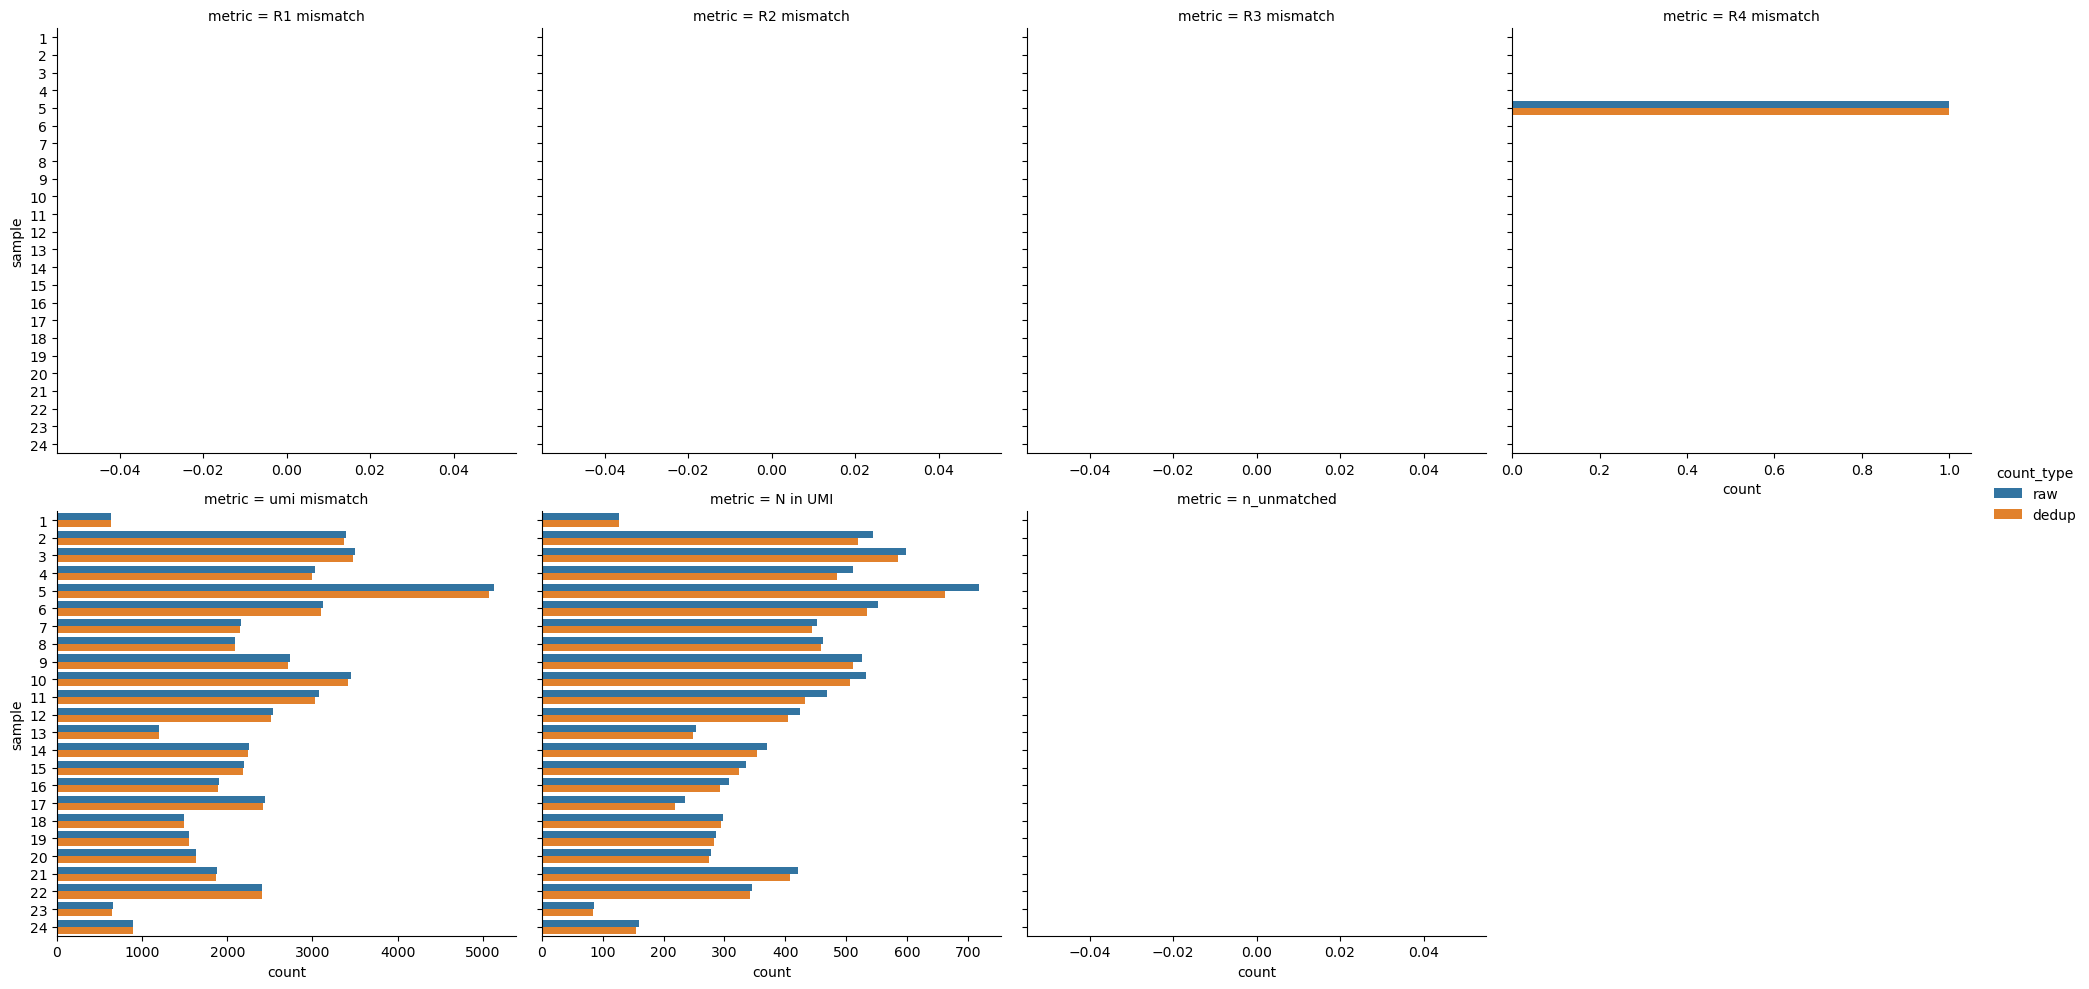

In [39]:
g = sns.catplot(
    kind='bar',
    data=df_umi_val_all,
    x='count',
    y='sample',
    hue='count_type',
    col='metric',
    col_wrap=4,
    sharex=False
)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


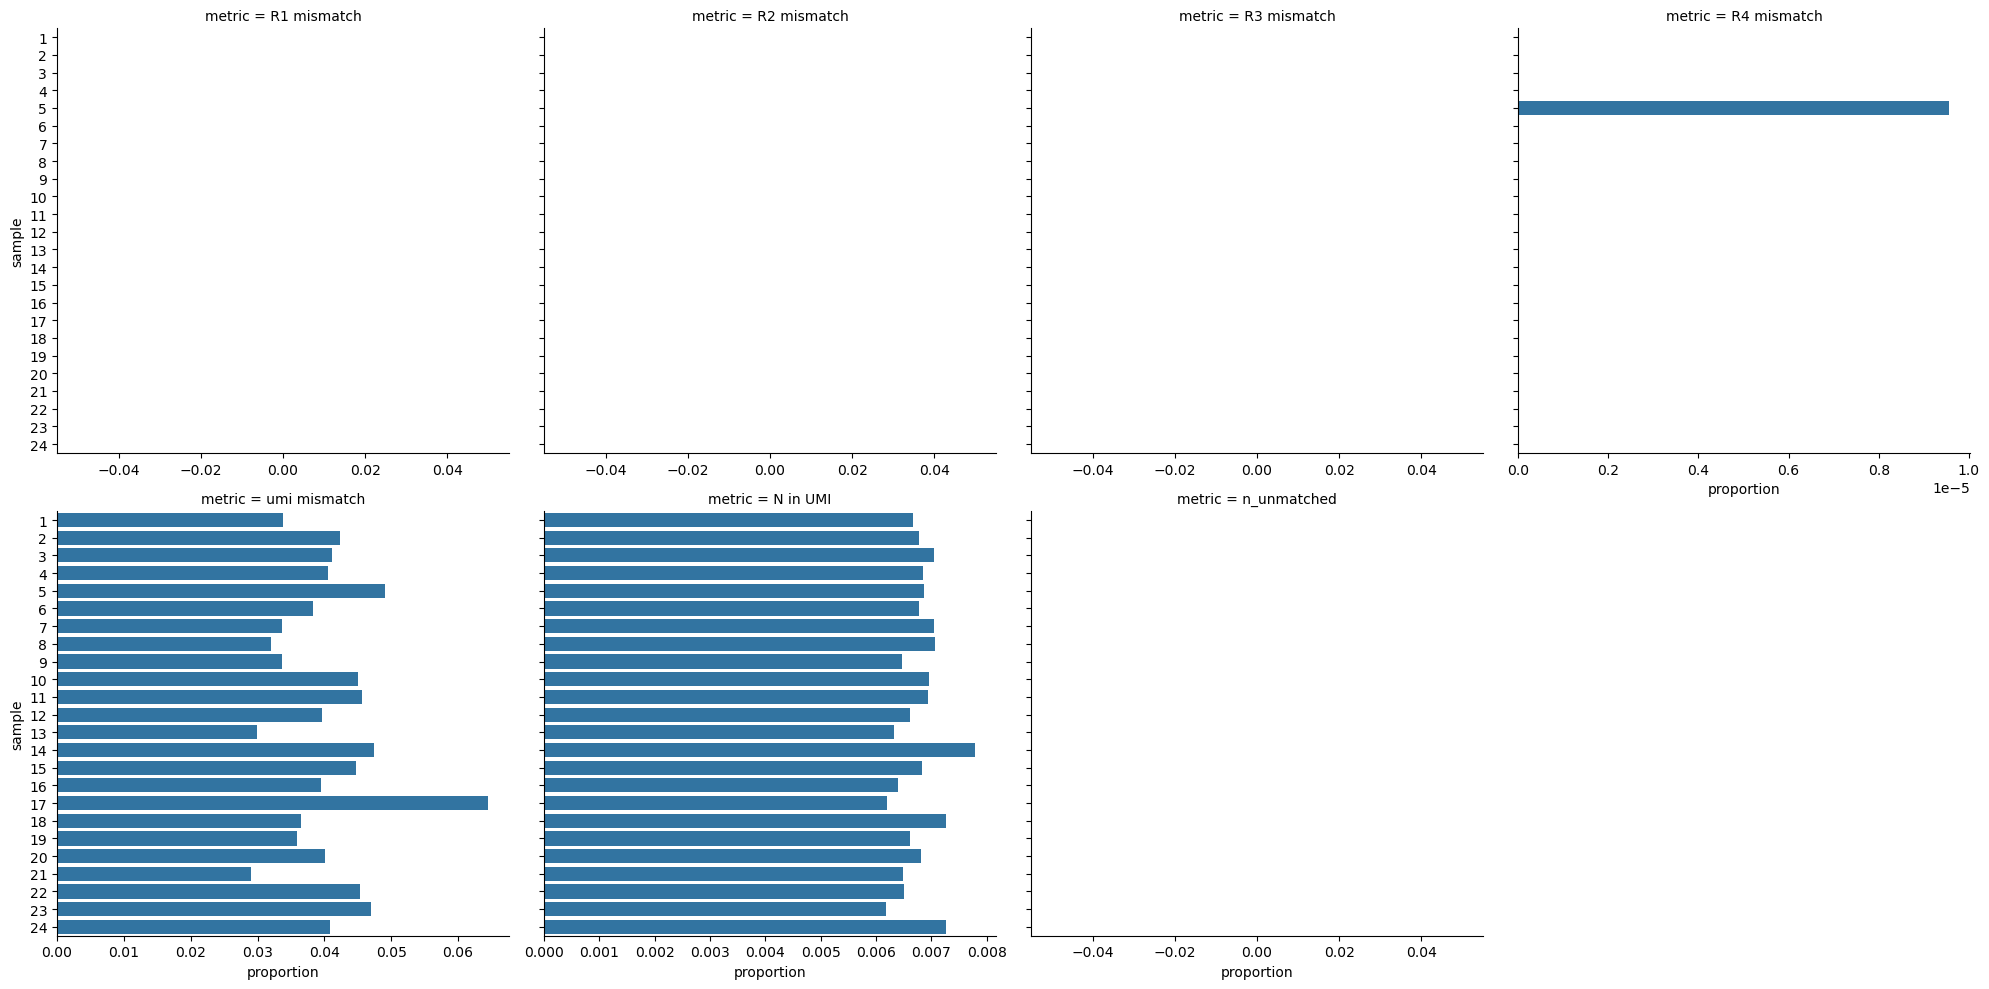

In [40]:
g = sns.catplot(
    kind='bar',
    data=(
        df_umi_val_all
        .loc[df_umi_val_all['count_type'] == 'raw']
        .drop(columns='count_type')
        .merge(df_data[['sample', 'n_assigned']].drop_duplicates('sample'))
        .pipe(lambda df: df.assign(proportion=df['count'] / df['n_assigned']))
        [['metric', 'sample', 'proportion']]
        .astype({'sample': 'category'})
    ),
    x='proportion',
    y='sample',
    col='metric',
    col_wrap=4,
    color='C0',
    sharex=False
)

# Ligation QC

Tag counts faceted by sample and round, grouped (colored) by count type (raw or deduplicated)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


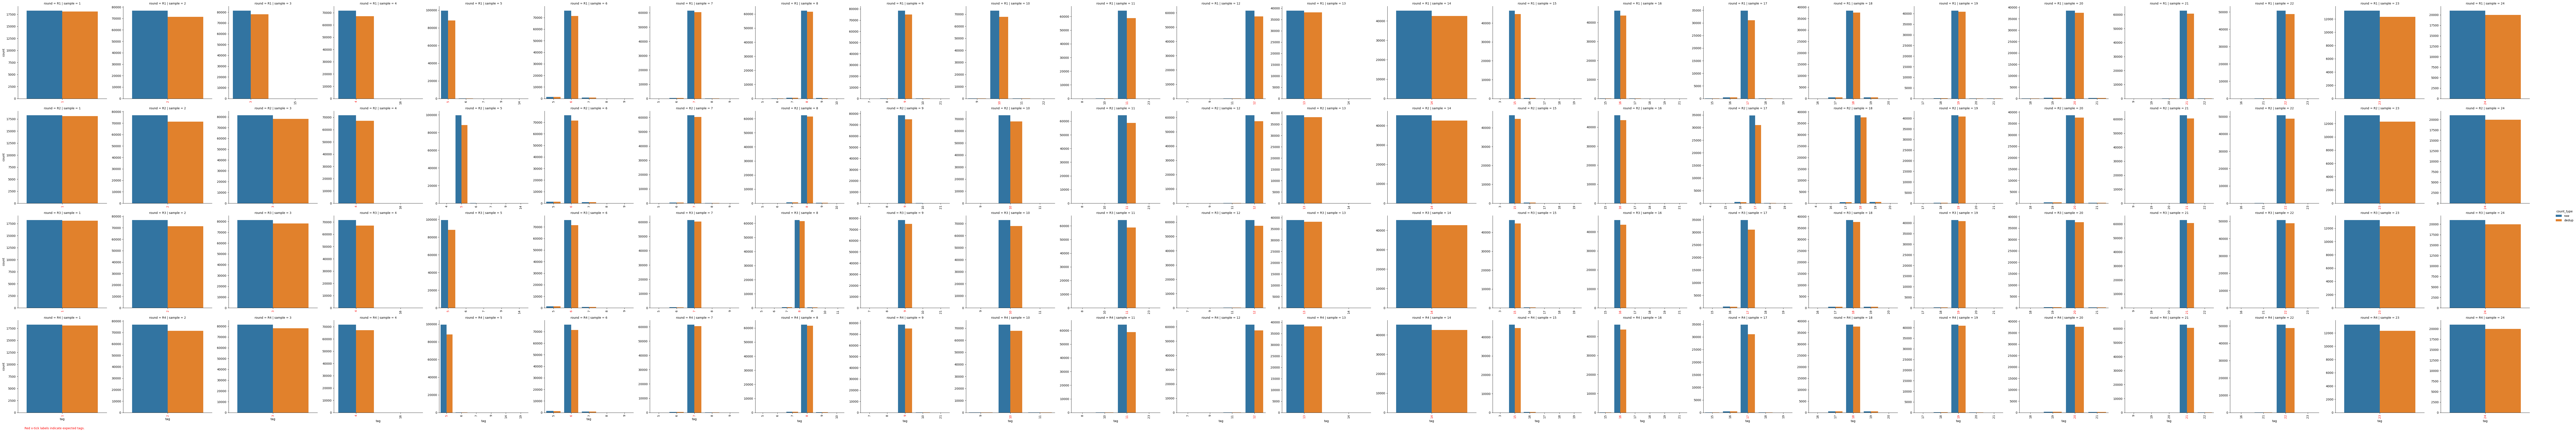

In [41]:
g = sns.catplot(
    df_tag_counts,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='count_type',
    col='sample',
    sharex=False,
    sharey='col'
)

# red color for xticklabels corresponding to expected tag
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) == sample:
            text.set_color('red')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

g.figure.text(
    0.01,
    -0.01,
    'Red x-tick labels indicate expected tags.',
    color='red',
    ha='left'
)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample.pdf'),
    bbox_inches='tight',
    dpi=300
)

Flow diagram (Sankey / parallel categories plot)

In [42]:
for sample in df_barcode_counts_all['sample'].unique():
    path_parcats = os.path.join(DIR_RESULTS, f'parcats_{sample}.pdf')
    if not os.path.exists(path_parcats) or reprocess:
        mask_sample = (df_barcode_counts_all['sample'] == sample)
        fig = go.Figure(go.Parcats(
            dimensions=[
                {
                    'label': r,
                    'values': df_barcode_counts_all.loc[mask_sample, r],
                    'categoryorder': 'category ascending'
                } for r in ROUNDS
            ],
            counts=df_barcode_counts_all.loc[mask_sample, 'count_dedup']))
        fig.update_layout(
            title_text=f'Sample: {sample}',
            width=600,
            height=600,
            margin=dict(l=10, b=10, t=50, r=10)
        )
        # fig.show()
        fig.write_image(path_parcats)

Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

In [43]:
fig = px.line(
    (
        df_barcode_counts_all
        .groupby('sample', group_keys=False)
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count_dedup'])),
               proportion=g['count_dedup'] / g['count_dedup'].sum()
           ).pipe(lambda g2: g2.loc[g2['rank'] < 6]))
        .reset_index()
        .melt(id_vars=['sample', 'rank'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='sample',
    facet_row='metric',
    markers=True,
    category_orders=dict(sample=sorted(df_data['sample'].unique())),
    color_discrete_sequence=sns.color_palette('cividis', n_colors=len(df_data['sample'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(
    matches=None,
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_xaxes(
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800,
    plot_bgcolor='#fff'
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank.png'), scale=2)
fig.show()

## Direct calculation of contamination

### Contamination by well

Barcodes are so clean that at least 3 of the 4 rounds of barcodes are "correct" for each barcode.

In [44]:
for _, row in df_barcode_counts_all.iterrows():
    well, count = collections.Counter(row[ROUNDS]).most_common(1)[0]
    if count <= 2:
        display(row)

Consequently, we can use the metric that 3 out of 4 rounds come from the same well as the "ground truth."

In [45]:
contamination = dict()
sensitivity = dict()
for well in range(1, 25):
    for r in ROUNDS:
        # number of oligos in the well: where other 3 rounds have tags matching the well
        mask = pd.Series([True] * len(df_barcode_counts_all))
        for r2 in ROUNDS:
            if r2 != r:
                mask &= df_barcode_counts_all[r2] == well
        total = df_barcode_counts_all.loc[mask, 'count_dedup'].sum()
        contaminated = df_barcode_counts_all.loc[mask & (df_barcode_counts_all[r] != well), 'count_dedup'].sum()
        contamination[(r, well)] = contaminated / total
        sensitivity[(r, well)] = 1 / total

In [46]:
df_contaminated = (
    pd.Series(contamination).reset_index()
    .rename(columns={'level_0': 'round', 'level_1': 'well', 0: 'proportion_contaminated'})
)
df_contaminated['col'] = (df_contaminated['well'] - 1) % 12 + 1
df_contaminated['row'] = (
    (df_contaminated['round'].str.extract('(\d)', expand=False).astype(int) - 1) * 2 + 
    (df_contaminated['well'] - 1) // 12
).map(lambda x: chr(ord('A') + x))
df_contaminated['round-row'] = df_contaminated['round'] + '-' + df_contaminated['row']

In [47]:
df_contaminated_wide = df_contaminated.pivot(index='round', columns='well', values='proportion_contaminated')
df_contaminated_wide_plate = df_contaminated.pivot(index='round-row', columns='col', values='proportion_contaminated')

In [48]:
ax = sns.heatmap(df_contaminated_wide_plate, cbar_kws={'label': 'proportion contaminated'})
ax.figure.suptitle('Contamination heatmap of SPRITE Zero R1-R4 tag plate')
ax.figure.savefig(
    os.path.join(DIR_RESULTS, 'contamination_heatmap_of_tag_plate.png'),
    bbox_inches='tight',
    dpi=300
)

In [49]:
print('Maximum tag well contamination proportion:', df_contaminated['proportion_contaminated'].max())

Maximum tag well contamination proportion: 0.0005065535363768758


In [50]:
print('Minimum sensitivity of assay:', '{:f}'.format(max(sensitivity.values())))

Minimum sensitivity of assay: 0.000081


#### Bayesian modeling of contamination proportion

We can model the proportion contamination using a Bayesian model:
- Let $X$ be the observed count of contaminated tags. Let $n$ be the number of total observed tags, and $p$ be the true proportion of contaminated tags.
- Binomial likelihood: $X \mid n, p \sim \mathrm{Binom}(n, p)$
  - We model $n$ (the number of assigned, deduplicated reads) as a known, fixed number.
- Prior (we choose a conjugate prior for convenience): $p \sim \mathrm{Beta}(\alpha = 0.4998, \beta = 49.21)$
  - Corresponds to placing 95% density between 0.00001 and 0.05 - see [Justin Bois's Distribution Explorer](https://distribution-explorer.github.io/continuous/beta.html).

By conjugacy, the posterior distribution is
$p \sim \mathrm{Beta}(\alpha + x, \beta + n - x)$

We compute the median and 2.5th to 97.5th percentiles of the posterior distribution of proportion contamination for each well.

In [51]:
alpha = 0.4998
beta = 49.21
prop_contamination_range = dict()
for well in range(1, 25):
    for r in ROUNDS:
        n = round(1 / sensitivity[(r, well)])
        x = round(contamination[(r, well)] * n)
        alpha_post = alpha + x
        beta_post = beta + n - x
        lb = scipy.stats.beta.ppf(0.025, alpha_post, beta_post)
        med = scipy.stats.beta.ppf(0.5, alpha_post, beta_post)
        assert np.isclose(med, scipy.stats.beta.median(alpha_post, beta_post), atol=1e-10)
        ub = scipy.stats.beta.ppf(0.975, alpha_post, beta_post)
        prop_contamination_range[(r, well)] = (lb, med, ub)

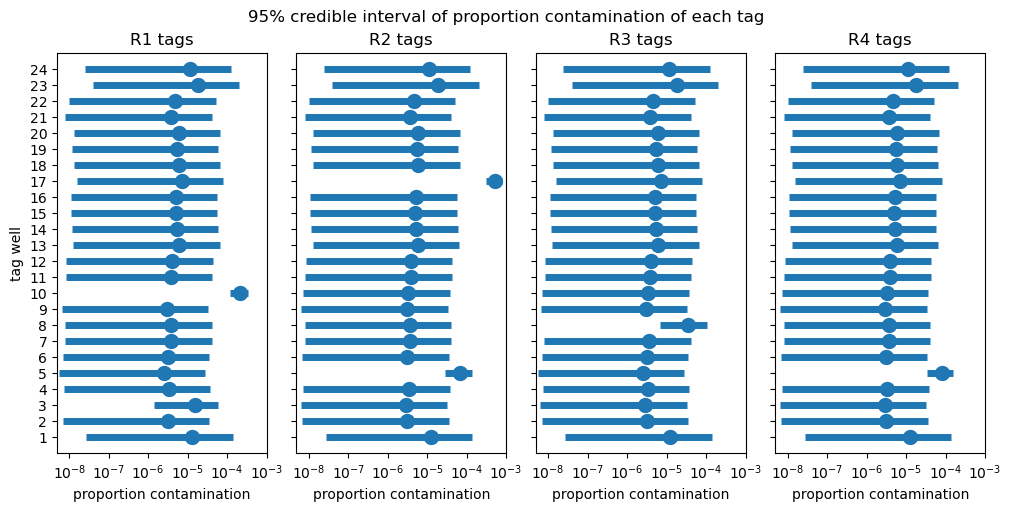

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10, 5), constrained_layout=True)
for i, r in enumerate(ROUNDS):
    axs[i].set_title(f'{r} tags')
    segs = []
    for well in range(1, 25):
        # line = (x0, y0), (x1, y1)
        lb, med, ub = prop_contamination_range[(r, well)]
        line = [(lb, well), (ub, well)]
        segs.append(line)
        axs[i].scatter(med, well, s=100, c='C0')
    line_segments = matplotlib.collections.LineCollection(segs, linewidths=5, linestyle='solid')
    axs[i].add_collection(line_segments)
    axs[i].set_xlabel('proportion contamination')
axs[0].set(
    xlim=(min(lb for lb, _, _ in prop_contamination_range.values()) * 0.9,
          max(ub for _, _, ub in prop_contamination_range.values()) * 1.1),
    ylim=(0, 25),
    xscale='log',
    ylabel='tag well'
)
axs[0].set_yticks(range(1, 25))
axs[0].set_xticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3])
fig.suptitle('95% credible interval of proportion contamination of each tag')
fig.savefig(os.path.join(DIR_RESULTS, 'contamination_credible_intervals.pdf'), bbox_inches='tight')

In [53]:
print('Maximum of 97.5% percentile of proportion contamination across all tags:',
      max(ub for _, _, ub in prop_contamination_range.values()))

Maximum of 97.5% percentile of proportion contamination across all tags: 0.000801598563943576


### Contamination by sample

These tags are even less contaminated than the i5/i7 multiplexing sequencing indices I used.

In [54]:
purity_per_sample = df_barcode_counts_all.groupby('sample').apply(lambda g: g['count_dedup'].max() / g['count_dedup'].sum())

In [55]:
purity_per_well = dict()
for well in range(1, 25):
    # mask to specify any row (i.e., sample-barcode combination) in df_barcode_counts_all
    # that has 3+ rounds matching the target well
    mask_all = pd.Series([False] * len(df_barcode_counts_all))

    # mask to specify rows where all 4 rounds match the target well
    mask_pure = pd.Series([True] * len(df_barcode_counts_all))
    for r in ROUNDS:
        # number of oligos in the well: where other 3 rounds have tags matching the well
        mask = pd.Series([True] * len(df_barcode_counts_all))
        for r2 in ROUNDS:
            if r2 != r:
                mask &= df_barcode_counts_all[r2] == well
        mask_all |= mask
        mask_pure &= df_barcode_counts_all[r] == well
    total = df_barcode_counts_all.loc[mask_all, 'count_dedup'].sum()
    pure = df_barcode_counts_all.loc[mask_pure, 'count_dedup'].sum()
    purity_per_well[well] = pure / total
purity_per_well = pd.Series(purity_per_well)

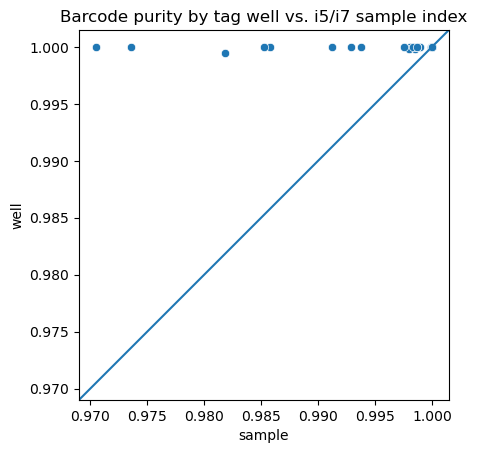

In [56]:
df_purity = pd.concat((purity_per_sample, purity_per_well), axis=1).rename(columns={0: 'sample', 1: 'well'})
ax = sns.scatterplot(df_purity, x='sample', y='well')
ax.axline((1, 1), slope=1)
ax.set_aspect('equal')
ax.set_title('Barcode purity by tag well vs. i5/i7 sample index')
ax.set(ylim=ax.get_xlim())
ax.figure.savefig(os.path.join(DIR_RESULTS, 'tag-purity_vs_i5-i7-sample-index-purity.pdf'), bbox_inches='tight')

# Sequencing Depth and Duplicates

## UMI distribution

In [57]:
umi_distribution = (
    df_umi_ecdf_long.groupby('count')['frequency'].sum()
    .pipe(lambda s: s/s.sum()).rename('proportion')
)
display(umi_distribution)
print('mean UMI count: {:.3f}'.format((np.array(umi_distribution.index) * umi_distribution).sum()))

count
0    0.000000
1    0.947787
2    0.050528
3    0.001647
4    0.000039
Name: proportion, dtype: float64

mean UMI count: 1.054


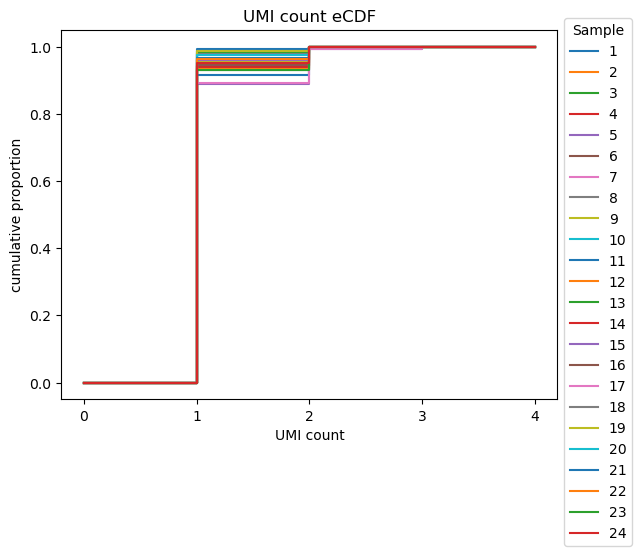

In [58]:
fig, ax = plt.subplots()
for sample in sorted(df_umi_ecdf_long['sample'].unique()):
    mask = (df_umi_ecdf_long['sample'] == sample)
    ax.step(
        df_umi_ecdf_long.loc[mask, 'count'],
        df_umi_ecdf_long.loc[mask, 'cumulative_prop'],
        where='post',
        label=sample
    )
ax.legend(title='Sample', loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set(xlabel='UMI count', ylabel='cumulative proportion', title='UMI count eCDF', xticks=range(df_umi_ecdf_long['count'].max() + 1))
fig.show()

## Estimate library complexity

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules, and therefore underestimates the true library complexity. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

In [59]:
def estimate_library_complexity(count_total, count_dedup, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, such that count_dedup molecules were sampled at least once. Solve
    for M.
    '''
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, count_total*1e5)
    )
    assert res.fun < max_err
    return res.x

In [60]:
umi_complexity = 4**12
print('Maximum UMI complexity:', umi_complexity)

Maximum UMI complexity: 16777216


Calculate the complexity of all barcodes in each sample.

In [61]:
complexity_umi_all = df_barcode_counts_all.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

Calculate the complexity of the predominant barcode in each sample.

In [62]:
complexity_umi_top = (
    df_barcode_counts_all
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.iloc[group["count"].argmax()][["count", "count_dedup"]])
    .apply(lambda s: estimate_library_complexity(s['count'], s['count_dedup']), axis=1)
)

### Plot

In [63]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top.rename('complexity_umi_est_top'),
            complexity_umi_all.rename('complexity_umi_est_all'),
            
        ),
        axis=1,
    ).reset_index(),
    how='left'
)

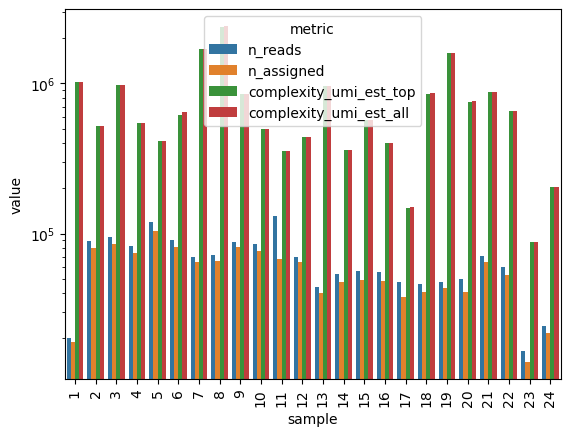

In [64]:
ax = sns.barplot(
    (
        df_data
        [['sample', 'n_reads', 'n_assigned', 'complexity_umi_est_top', 'complexity_umi_est_all']]
        .drop_duplicates()
        .melt(id_vars='sample')
        .rename(columns={'variable': 'metric'})
    ),
    x='sample',
    y='value',
    hue='metric'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yscale('log')
ax.figure.show()

### Estimates of total library complexity

Estimate from count numbers from pooling all samples

In [65]:
'{:g}'.format(estimate_library_complexity(df_barcode_counts_all['count'].sum(), df_barcode_counts_all['count_dedup'].sum()))

'1.19122e+07'

Sum of estimate of each sample - probably more accurate, since each sample likely had slightly different duplication rates as a result of less-than-perfectly-even pooling and different amplification rates for each sample.

In [66]:
'{:g}'.format(complexity_umi_all.sum())

'1.79033e+07'

Note that these 2 values above only count reads for which barcodes were identified.

Estimate from Qubit values
- 6.53 nM * 20 uL = pooled library
  - This represents 1/10th of total, since I only pooled 2 uL out of 20 uL from each of the 24 samples
- Account for 7 cycles of PCR
- Assume no loss upon gel cut

In [67]:
complexity_qubit = 6.53e-9 * 20e-6 * 10 / 2**7 * 6.022e23
'{:g}'.format(complexity_qubit)

'6.14432e+09'

Compare with estimated amount of oligo that went into PCR

In [68]:
'{:g}'.format(0.025e-12 * 24 * 6.022e23)

'3.6132e+11'

## Estimated coverage and duplication rate

"Coverage" = proportion of physical molecules that were sequenced and assigned.
- Assume sampling `n_assigned` reads from `complexity_qubit` molecules.

In [69]:
complexity_umi_all.sum() / complexity_qubit

0.0029137929463852684

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [70]:
(
    df_barcode_counts_all[['sample', 'count', 'count_dedup']]
    .groupby(['sample']).sum()
    .pipe(lambda df: df.assign(duplication_rate=(df['count'] - df['count_dedup'])/df['count']))
)

count  count_dedup  duplication_rate
sample                                      
1       18261        18100          0.008817
2       76844        71411          0.070702
3       81421        78123          0.040506
4       71676        67150          0.063145
5       99588        88520          0.111138
6       78270        73681          0.058630
7       62033        60918          0.017974
8       63290        62466          0.013019
9       78628        75131          0.044475
10      73102        68007          0.069697
11      64351        58860          0.085329
12      61666        57570          0.066422
13      38953        38172          0.020050
14      45310        42596          0.059898
15      46907        45044          0.039717
16      46284        43728          0.055224
17      35494        31621          0.109117
18      39535        38651          0.022360
19      41662        41125          0.012889
20      39142        38158          0.025139
21      62943        60731          0.035143
22      50836        48905          0.037985
23      13255        12310          0.071294
24      21003        19967          0.049326

# Compare with exact matching

## Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [barcode + UMI]
  - format: n/a
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `R4` `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts per barcode
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `R4`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: deduplicated counts per tag
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count` (deduplicated)

In [71]:
path_umi_validation_exact = os.path.join(DIR_RESULTS, 'umi_validation_exact.csv')
path_tag_counts_exact = os.path.join(DIR_RESULTS, 'tag_counts_exact.csv')
path_barcode_counts_exact = os.path.join(DIR_RESULTS, 'barcode_counts_exact.csv')
path_umi_ecdf_exact = os.path.join(DIR_RESULTS, 'umi_ecdf_exact.csv')

In [72]:
reprocess = not all(os.path.exists(path) for path in [path_umi_validation_exact, path_tag_counts_exact, path_barcode_counts_exact, path_umi_ecdf_exact])
print('reprocess:', reprocess)

reprocess: False


In [73]:
if reprocess:
    df_umi_val_all_exact = {}
    df_umi_ecdf_exact = {}
    df_barcode_counts_all_exact = {}

In [74]:
if reprocess:
    for sample in df_data['sample'].unique():
        path_barcodes = os.path.join(DIR_PROC, f'read_barcodes_exact-{sample}.txt.gz')
        df_barcode_counts, df_umi_counts, n_unmatched, unmatched = count_barcodes(sample, regex_barcode, path_barcodes)
        if n_unmatched > 0:
            print((
                f'Sample {sample}: {n_unmatched} reads had barcodes [+ UMIs] that did not match '
                f'the regex. {min(3, n_unmatched)} / {n_unmatched} unmatched barcode-appended '
                'read names are printed below:'))
            for i in range(min(3, n_unmatched)):
                print('-', unmatched[i])
        df_umi_val_all_exact[sample] = (
            umi_df_to_validation(df_umi_counts, n_unmatched)
            .assign(sample=sample)
            .astype(dict(sample=DTYPE_SAMPLE))
        )
        df_umi_ecdf_exact[sample] = df_umi_counts['count'].value_counts()
        df_barcode_counts_all_exact[sample] = df_barcode_counts.assign(sample=sample).astype(dict(sample=DTYPE_SAMPLE))

### Save / Load Processed Data

In [75]:
if reprocess:
    df_umi_val_all_exact = pd.concat(df_umi_val_all_exact.values(), axis=0, ignore_index=True)
    df_umi_val_all_exact.to_csv(path_umi_validation_exact, index=False)
else:
    df_umi_val_all_exact = pd.read_csv(path_umi_validation_exact, index_col=False)

In [76]:
if reprocess:
    df_barcode_counts_all_exact = pd.concat(df_barcode_counts_all_exact.values(), axis=0, ignore_index=True)
    df_barcode_counts_all_exact.to_csv(path_barcode_counts_exact, index=False)
else:
    df_barcode_counts_all_exact = pd.read_csv(
        path_barcode_counts_exact,
        dtype={
            'R1': np.uint8,
            'R2': np.uint8,
            'R3': np.uint8,
            'R4': np.uint8,
            'count': np.int64,
            'count_dedup': np.int64,
            'sample': DTYPE_SAMPLE,
        },
        index_col=False
    )

In [77]:
if reprocess:
    df_umi_ecdf_long_exact = (
        pd.concat((pd.concat((pd.Series(0), s)) for s in df_umi_ecdf_exact.values()), axis=1)
        .fillna(0)
        .astype(int)
        .sort_index()
        .reset_index(names='count')
        .melt(id_vars='count', var_name='sample', value_name='frequency')
        .groupby('sample', group_keys=False)
        .apply(lambda g: (
            g.sort_values('count')
            .pipe(lambda g2: g.assign(cumulative_prop=g['frequency'].cumsum() / g['frequency'].sum()))
        ))
        .pipe(lambda df: df.assign(sample=df['sample'].map(lambda i: list(df_umi_ecdf_exact.keys())[i])))
    )
    df_umi_ecdf_long_exact.to_csv(path_umi_ecdf_exact, index=False)
else:
    df_umi_ecdf_long_exact = pd.read_csv(path_umi_ecdf_exact, index_col=False, dtype={'sample': DTYPE_SAMPLE})

In [78]:
if reprocess:
    df_tag_counts_exact = (
        df_barcode_counts_all_exact
        .rename(columns=dict(count='raw', count_dedup='dedup'))
        .melt(
            id_vars=ROUNDS + ['sample'],
            var_name='count_type',
            value_name='count'
        )
        .melt(
            id_vars=['sample', 'count_type', 'count'],
            value_vars=ROUNDS,
            var_name='round',
            value_name='tag'
        )
        .groupby(['sample', 'count_type', 'round', 'tag'], observed=True)
        ['count'].sum()
        .reset_index()
        .astype(dict(round=DTYPE_ROUNDS))
    )
    df_tag_counts_exact.to_csv(path_tag_counts_exact, index=False)
else:
    df_tag_counts_exact = pd.read_csv(
        path_tag_counts_exact,
        index_col=False,
        dtype=dict(
            sample=DTYPE_SAMPLE,
            count_type=DTYPE_COUNT_TYPE,
            round=DTYPE_ROUNDS,
            tag=np.uint8
        )
    )

## Validation

All assigned reads had read structures and UMIs matching expected regex.

In [79]:
df_umi_val_all_exact.loc[df_umi_val_all_exact['metric'] == 'n_unmatched', 'count'].unique()

array([0])

A negligible proportion of reads have different tags identified in read 1 vs. read 2, but there was a more sizeable proportion (up to ~2.5%) of reads with different UMIs identified in read 1 vs. read 2.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



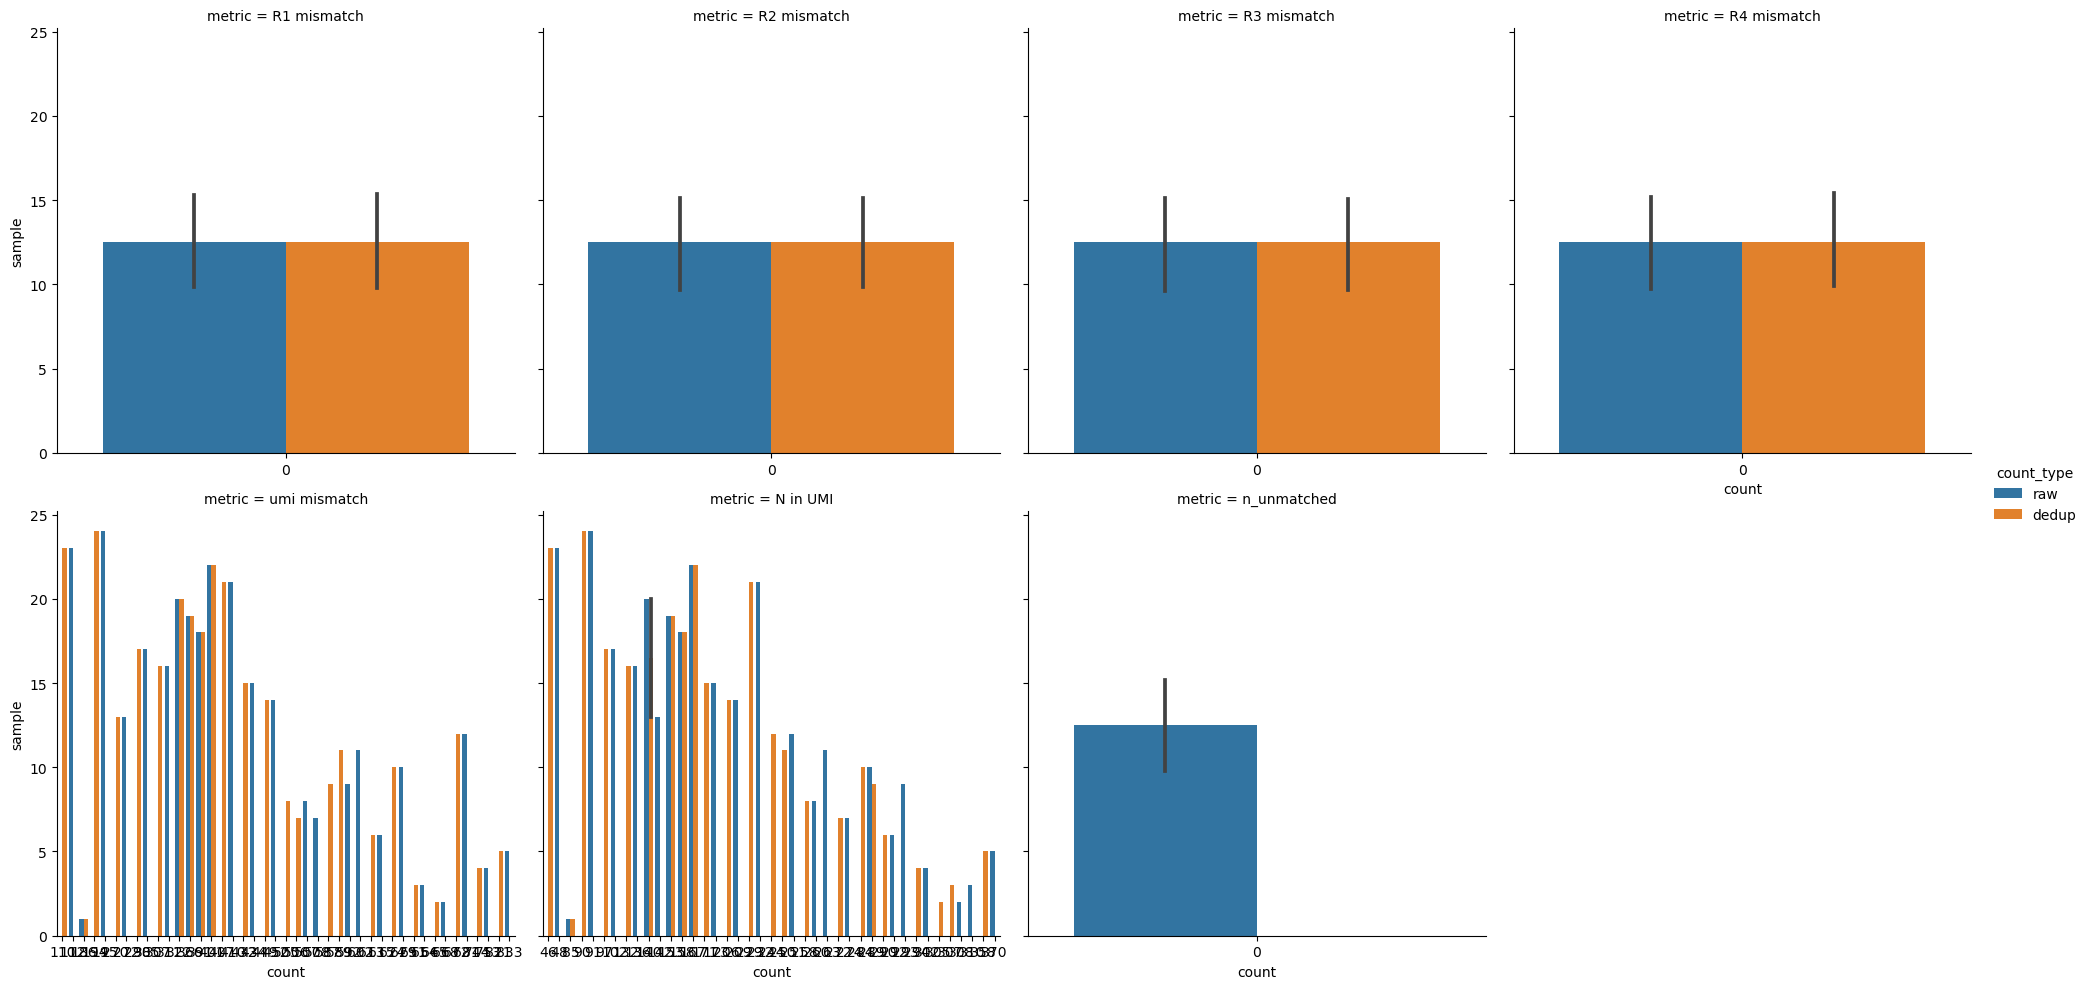

In [80]:
g = sns.catplot(
    kind='bar',
    data=df_umi_val_all_exact,
    x='count',
    y='sample',
    hue='count_type',
    col='metric',
    col_wrap=4,
    sharex=False
)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



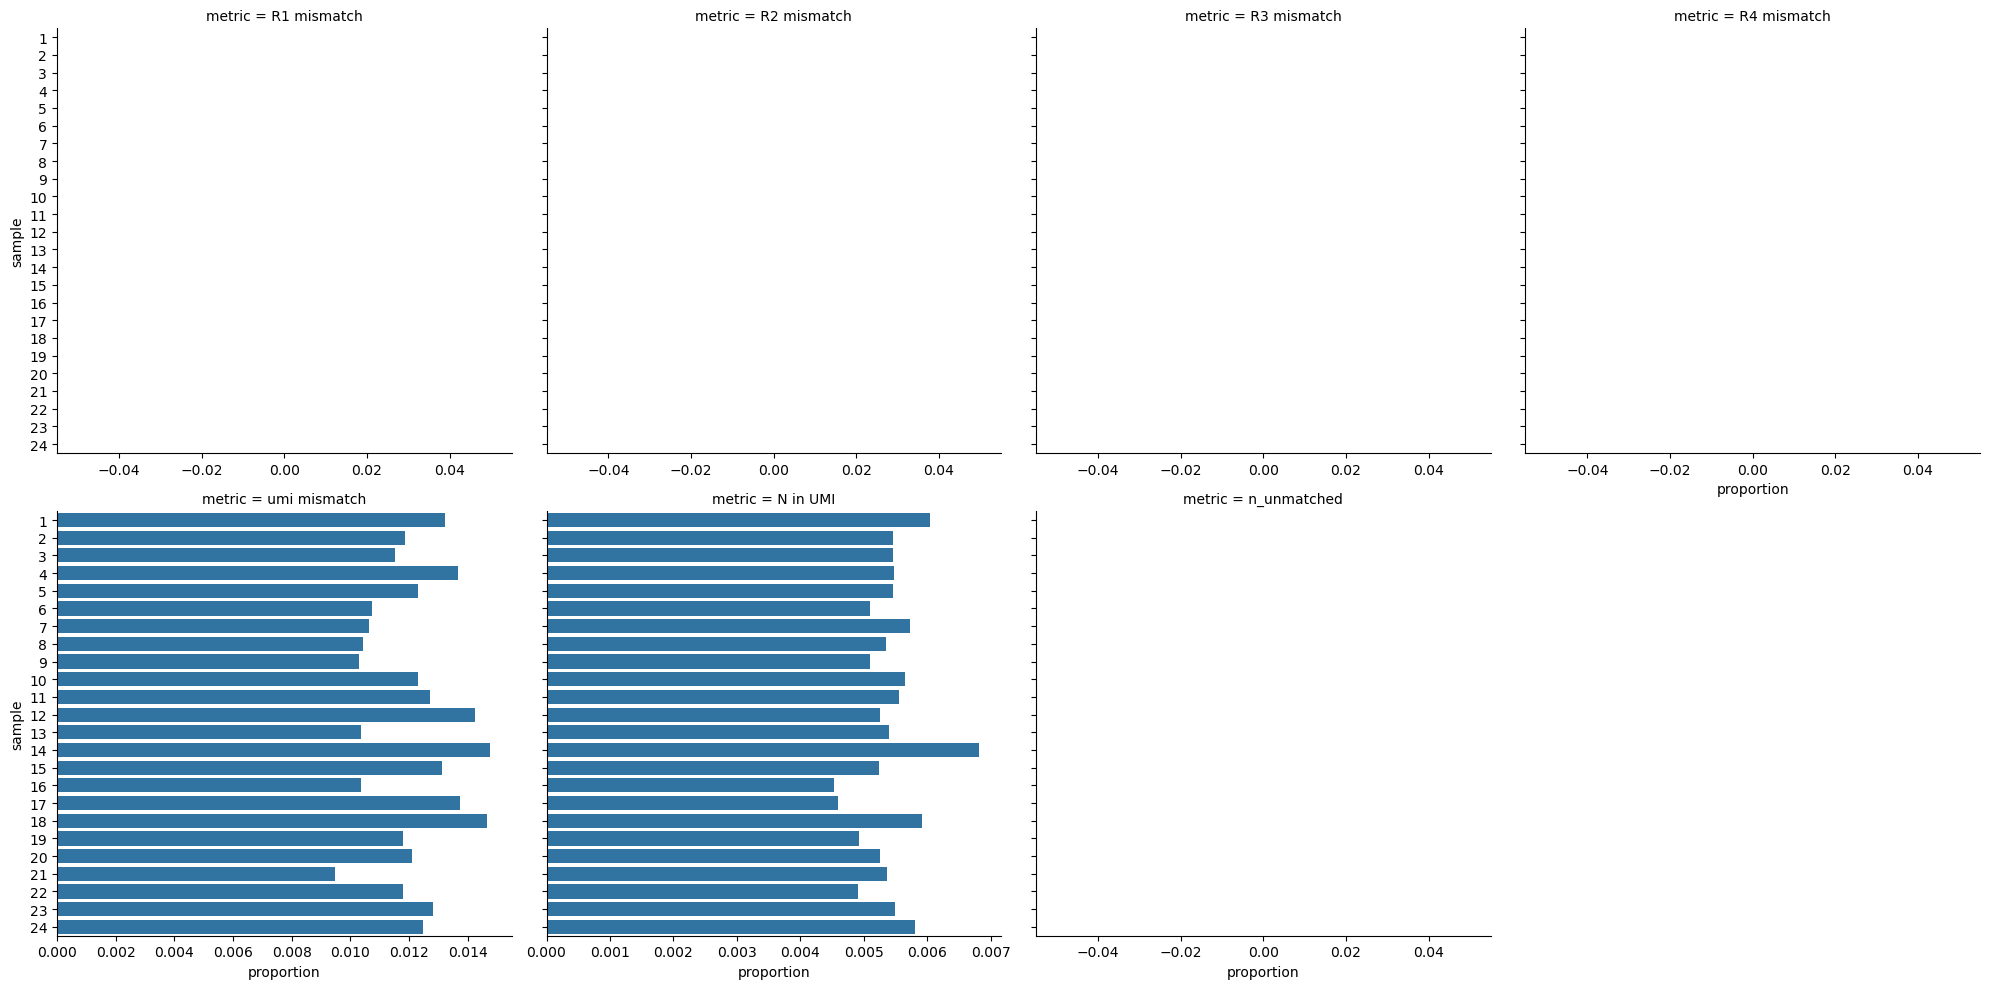

In [81]:
g = sns.catplot(
    kind='bar',
    data=(
        df_umi_val_all_exact
        .loc[df_umi_val_all_exact['count_type'] == 'raw']
        .drop(columns='count_type')
        .merge(df_data[['sample', 'n_assigned_exact']].drop_duplicates('sample'))
        .pipe(lambda df: df.assign(proportion=df['count'] / df['n_assigned_exact']))
        [['metric', 'sample', 'proportion']]
        .astype({'sample': 'category'})
    ),
    x='proportion',
    y='sample',
    col='metric',
    col_wrap=4,
    color='C0',
    sharex=False
)

## Ligation QC

Tag counts faceted by sample and round, grouped (colored) by count type (raw or deduplicated)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



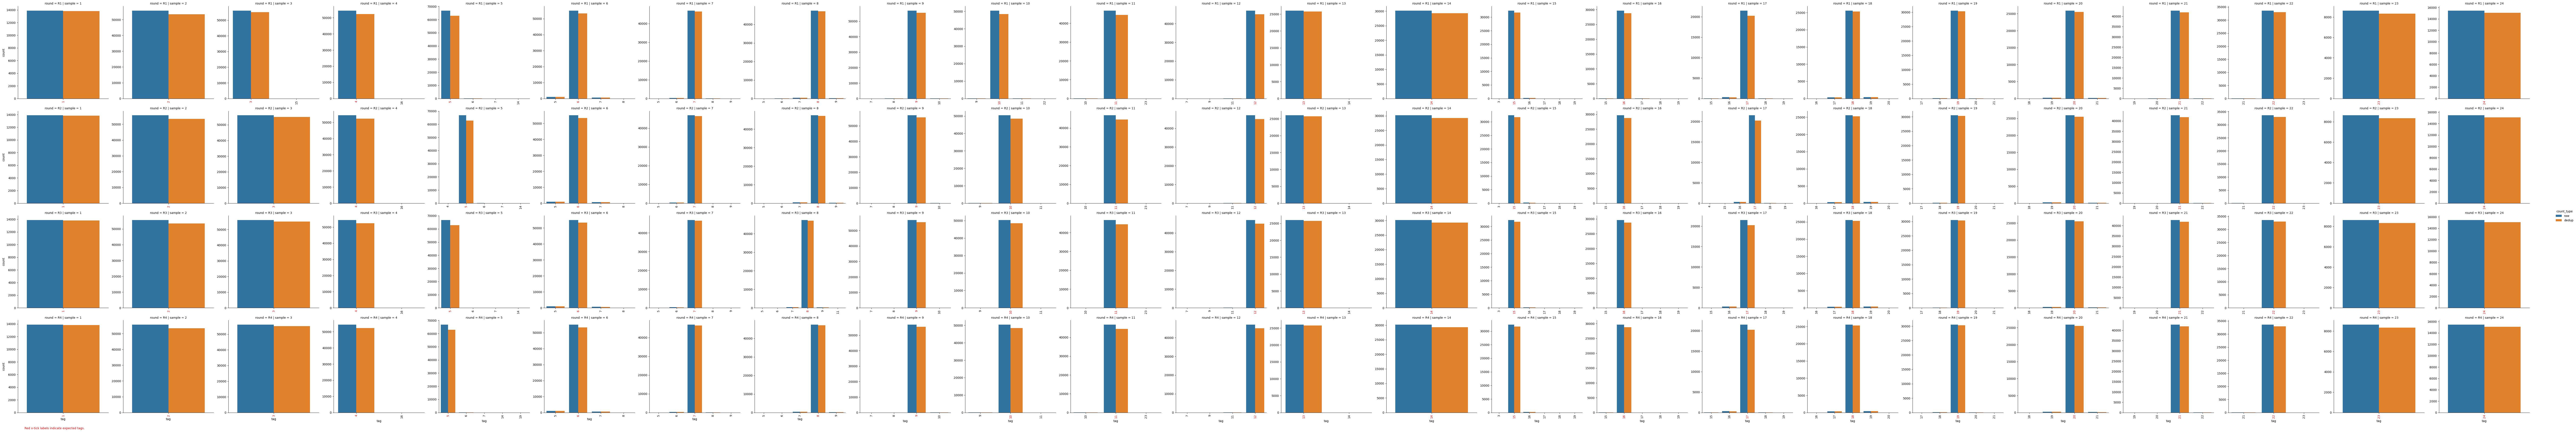

In [82]:
g = sns.catplot(
    df_tag_counts_exact,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='count_type',
    col='sample',
    sharex=False,
    sharey='col'
)

# red color for xticklabels corresponding to expected tag
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) == sample:
            text.set_color('red')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

g.figure.text(
    0.01,
    -0.01,
    'Red x-tick labels indicate expected tags.',
    color='red',
    ha='left'
)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample_exact.pdf'),
    bbox_inches='tight',
    dpi=300
)

Flow diagram (Sankey / parallel categories plot)

In [83]:
for sample in df_barcode_counts_all_exact['sample'].unique():
    mask_sample = (df_barcode_counts_all_exact['sample'] == sample)
    fig = go.Figure(go.Parcats(
        dimensions=[
            {
                'label': r,
                'values': df_barcode_counts_all_exact.loc[mask_sample, r],
                'categoryorder': 'category ascending'
            } for r in ROUNDS
        ],
        counts=df_barcode_counts_all_exact.loc[mask_sample, 'count_dedup']))
    fig.update_layout(
        title_text=f'Sample: {sample}',
        width=600,
        height=600,
        margin=dict(l=10, b=10, t=50, r=10)
    )
    # fig.show()
    fig.write_image(os.path.join(DIR_RESULTS, f'parcats_exact_{sample}.pdf'))

Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

In [84]:
fig = px.line(
    (
        df_barcode_counts_all
        .groupby('sample', group_keys=False)
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count_dedup'])),
               proportion=g['count_dedup'] / g['count_dedup'].sum()
           ).pipe(lambda g2: g2.loc[g2['rank'] < 6]))
        .reset_index()
        .melt(id_vars=['sample', 'rank'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='sample',
    facet_row='metric',
    markers=True,
    category_orders=dict(sample=sorted(df_data['sample'].unique())),
    color_discrete_sequence=sns.color_palette('cividis', n_colors=len(df_data['sample'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(
    matches=None,
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_xaxes(
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800,
    plot_bgcolor='#fff'
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank.png'), scale=2)
fig.show()

In [85]:
fig = px.line(
    (
        df_barcode_counts_all_exact
        .groupby('sample', group_keys=False)
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count_dedup'])),
               proportion=g['count_dedup'] / g['count_dedup'].sum()
           ).pipe(lambda g2: g2.loc[g2['rank'] < 6]))
        .reset_index()
        .melt(id_vars=['sample', 'rank'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='sample',
    facet_row='metric',
    markers=True,
    category_orders=dict(sample=sorted(df_data['sample'].unique())),
    color_discrete_sequence=sns.color_palette('cividis', n_colors=len(df_data['sample'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(
    matches=None,
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_xaxes(
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800,
    plot_bgcolor='#fff'
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank_exact.png'), scale=2)
fig.show()

## Sequencing Depth and Duplicates

### UMI distribution

In [86]:
umi_distribution_exact = (
    df_umi_ecdf_long_exact.groupby('count')['frequency'].sum()
    .pipe(lambda s: s/s.sum()).rename('proportion')
)
display(umi_distribution_exact)
print('mean UMI count: {:.3f}'.format((np.array(umi_distribution_exact.index) * umi_distribution_exact).sum()))

count
0    0.000000
1    0.971457
2    0.028037
3    0.000495
4    0.000011
Name: proportion, dtype: float64

mean UMI count: 1.029


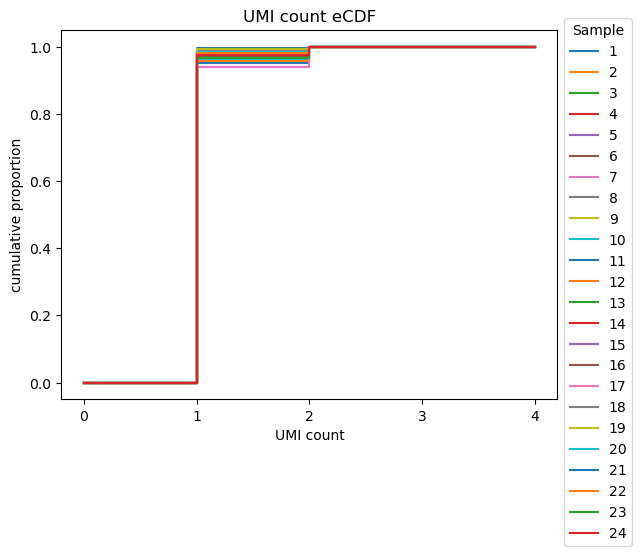

In [87]:
fig, ax = plt.subplots()
for sample in sorted(df_umi_ecdf_long_exact['sample'].unique()):
    mask = (df_umi_ecdf_long_exact['sample'] == sample)
    ax.step(
        df_umi_ecdf_long_exact.loc[mask, 'count'],
        df_umi_ecdf_long_exact.loc[mask, 'cumulative_prop'],
        where='post',
        label=sample
    )
ax.legend(title='Sample', loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set(xlabel='UMI count', ylabel='cumulative proportion', title='UMI count eCDF', xticks=range(df_umi_ecdf_long_exact['count'].max() + 1))
fig.show()

### Estimate library complexity

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules, and therefore underestimates the true library complexity. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

Calculate the complexity of all barcodes in each sample.

In [88]:
complexity_umi_all_exact = df_barcode_counts_all_exact.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

Calculate the complexity of the predominant barcode in each sample.

In [89]:
complexity_umi_top_exact = (
    df_barcode_counts_all_exact
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.iloc[group["count"].argmax()][["count", "count_dedup"]])
    .apply(lambda s: estimate_library_complexity(s['count'], s['count_dedup']), axis=1)
)

#### Plot

In [90]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top_exact.rename('complexity_umi_est_top_exact'),
            complexity_umi_all_exact.rename('complexity_umi_est_all_exact'),
            
        ),
        axis=1,
    ).reset_index(),
    how='left'
)

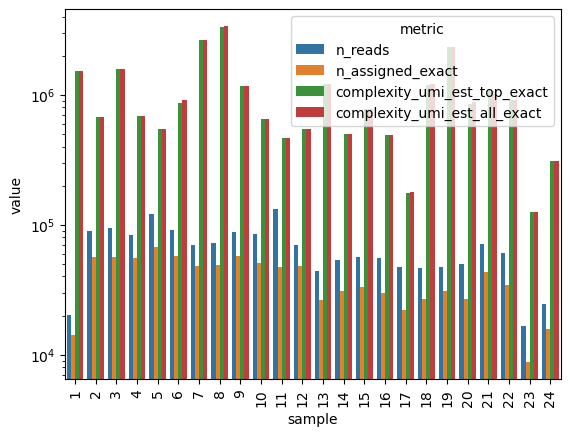

In [91]:
ax = sns.barplot(
    (
        df_data
        [['sample', 'n_reads', 'n_assigned_exact', 'complexity_umi_est_top_exact', 'complexity_umi_est_all_exact']]
        .drop_duplicates()
        .melt(id_vars='sample')
        .rename(columns={'variable': 'metric'})
    ),
    x='sample',
    y='value',
    hue='metric'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yscale('log')
ax.figure.show()

#### Estimates of total library complexity

Estimate from count numbers from pooling all samples

In [92]:
'{:g}'.format(estimate_library_complexity(df_barcode_counts_all_exact['count'].sum(), df_barcode_counts_all_exact['count_dedup'].sum()))

'1.59194e+07'

Sum of estimate of each sample - probably more accurate, since each sample likely had slightly different duplication rates as a result of less-than-perfectly-even pooling and different amplification rates for each sample.

In [93]:
'{:g}'.format(complexity_umi_all_exact.sum())

'2.47962e+07'

Note that these 2 values above only count reads for which barcodes were identified.

### Estimated coverage and duplication rate

"Coverage" = proportion of physical molecules that were sequenced and assigned.
- Assume sampling `n_assigned` reads from `complexity_qubit` molecules.

In [94]:
complexity_umi_all_exact.sum() / complexity_qubit

0.004035628839647363

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [95]:
(
    df_barcode_counts_all_exact[['sample', 'count', 'count_dedup']]
    .groupby(['sample']).sum()
    .pipe(lambda df: df.assign(duplication_rate=(df['count'] - df['count_dedup'])/df['count']))
)

count  count_dedup  duplication_rate
sample                                      
1       13888        13825          0.004536
2       55679        53432          0.040356
3       56064        55087          0.017427
4       54393        52312          0.038259
5       66894        62944          0.059049
6       56672        54943          0.030509
7       47289        46867          0.008924
8       48124        47783          0.007086
9       56927        55558          0.024048
10      50489        48593          0.037553
11      46776        44513          0.048380
12      47071        45108          0.041703
13      26018        25740          0.010685
14      30182        29284          0.029753
15      32620        31947          0.020632
16      29702        28814          0.029897
17      21899        20606          0.059044
18      26301        26020          0.010684
19      30683        30484          0.006486
20      26307        25915          0.014901
21      42841        41990          0.019864
22      33653        33039          0.018245
23       8634         8344          0.033588
24      15457        15079          0.024455